# HR-аналитика

**Цель**
Предсказание уровня удовлетворённости и увольнение сотрудников в компании «Работа с заботой».

**Задачи**
1. Предсказать уровня удовлетворённости сотрудника
2. Предсказать увольнения сотрудника из компании
**План проекта**

[**Задача 1**](#1)

1. [Загрузка данных](#11)

    1. [Загрузить данные](#111)
    
    2. [Проверить, что данные в таблицах соответствуют описанию](#112)
    
    3. [Вывод](#113)
    
2. [Предобработка данных](#12)

    1. [Исследование явных дубликатов](#121)
    
    2. [Проверка уникальных значения в столбцах](#122)
    
    3. [Работа с пропусками](#123)
    
    4. [Вывод](#124)
    
3. [Исследовательский анализ данных](#13)
    
    1. [Исследование категориальных признаков](#131)
    
    2. [Исследование количественных признаков](#132)
    
    3. [Корреляционный анализ](#133)
    
    4. [Вывод](#134)
    
4. [Подготовка данных](#14)

    1. [Подготовка пайплайна](#141)
    
    2. [Вывод](#142)
    
5. [Обучение моделей](#15)

    1. [Метрика SAMPE](#151)
    
    2. [Поиск лучше модели для SAMPE](#152)
    
    3. [Вывод](#153)
    
6. [Выводы по задачи 1](#16)

[**Задача 2**](#2)
    
1. [Загрузка данных](#21)

    1. [Загрузить данные](#211)
    
    2. [Проверить, что данные в таблицах соответствуют описанию](#212)
    
    3. [Вывод](#213)
    
2. [Предобработка данных](#22)
    
    1. [Исследование явных дубликатов](#221)
    
    2. [Проверка уникальных значения в столбцах](#222)
    
    3. [Вывод](#223)
    
3. [Исследовательский анализ данных](#23)
    
    1. [Исследование категориальных признаков](#231)
    
    2. [Исследование количественных признаков](#232)
    
    3. [Портрет «уволившегося сотрудника»](#233)
    
    4. [Анализ уровеня удовлетворённости и уволнения](#234)
    
    5. [Корреляционный анализ](#235)
    
    6. [Вывод](#236)
    
4. [Добавление нового входного признака](#24)
    
5. [Подготовка данных](#25)
    
6. [Обучение моделей](#26)

7. [Выводы по задачи 2](#27)

[Общий вывод по проекту](#3)

**Описание данных**

**Задача 1**

Даны 3 датасета: `train_job_satisfaction_rate.csv` - тренировочная выборка, `test_features.csv` -входные признаки тестовой выборки, `test_target_job_satisfaction_rate.csv` - Целевой признак тестовой выборки.

**Задача 2**

Даны 3 датасета: `train_quit.csv` - тренировочная выборка, `test_features.csv` -входные признаки тестовой выборки, `test_target_quit.csv` - Целевой признак тестовой выборки.

В датасетах есть следующие признаки:

- `id` — уникальный идентификатор сотрудника;
- `dept` — отдел, в котором работает сотрудник;
- `level` — уровень занимаемой должности;
- `workload` — уровень загруженности сотрудника;
- `employment_years` — длительность работы в компании (в годах);
- `last_year_promo` — показывает, было ли повышение за последний год;
- `last_year_violations` — показывает, нарушал ли сотрудник трудовой договор за последний год;
- `supervisor_evaluation` — оценка качества работы сотрудника, которую дал руководитель;
- `salary` — ежемесячная зарплата сотрудника;
- `job_satisfaction_rate` — уровень удовлетворённости сотрудника работой в компании, целевой признак для задачи 1;
- `quit` — увольнение сотрудника из компании, целевой признак для задачи 2.


In [1]:
!pip install phik -q

In [2]:
#библиотеки

import os
from io import StringIO # выод пропусков

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# для статистического анализа
from scipy import stats as st
from scipy.stats import shapiro, ttest_ind

# для работы с графиками
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import phik
from phik.report import plot_correlation_matrix
from phik import report


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, LabelEncoder

from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.dummy import DummyRegressor, DummyClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


# импортируйте нужные классы для работы с пропусками
from sklearn.impute import SimpleImputer 

In [3]:
pd.set_option('display.max_columns', None) # вывод всех колонок датафрейма

# укажем формат отображения больших чисел,
pd.set_option('display.float_format', '{:.2f}'.format) # отображение чисел с 2 знаками после запятой

RANDOM_STATE = 42

In [4]:
!pip install scikit-learn -U -q

In [5]:
!pip install matplotlib -U -q

In [6]:
!pip install seaborn -U -q

# Задача 1 Предсказание уровня удовлетворённости сотрудника <a id='1'></a>

## Загрузка данных <a id='11'></a>

### Загрузить данные <a id='111'></a>

Загрузим датасеты `train_job_satisfaction_rate.csv`, `test_features.csv`, `test_target_job_satisfaction_rate.csv`.

In [7]:
train = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_job_satisfaction_rate = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')

Датасеты загружены.

### Проверить, что данные в таблицах соответствуют описанию. <a id='112'></a>

Напишем функцию для описания данных в таблицах.

In [8]:
def info_df(data):
    display(data.info())
    display(data.describe())
    display(data.head(10))

In [9]:
info_df(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


None

,id,employment_years,supervisor_evaluation,salary,job_satisfaction_rate
count,4000.00,4000.00,4000.00,4000.00,4000.00
mean,544957.62,3.72,3.48,33926.70,0.53
std,257883.10,2.54,1.01,14900.70,0.23
min,100954.00,1.00,1.00,12000.00,0.03
25%,322836.75,2.00,3.00,22800.00,0.36
50%,534082.50,3.00,4.00,30000.00,0.56
75%,771446.00,6.00,4.00,43200.00,0.71
max,999521.00,10.00,5.00,98400.00,1.00


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20
5,405448,hr,middle,low,7,no,no,4,30000,0.78
6,857135,sales,sinior,medium,9,no,no,3,56400,0.56
7,400657,purchasing,middle,high,9,no,no,3,52800,0.44
8,198846,hr,junior,low,1,no,no,2,13200,0.14
9,149797,technology,middle,high,6,no,no,3,54000,0.47


В датасете `train_job_satisfaction_rate`:
- 4000 записей, есть 6 пропусков в `dept` и 4 в `level`;
- Типы значений соотвтсвуют сформированным выборкам;
- Описательная статистика для данного датасета выглядет вполне реалистичной;
- Названия столбцов не выбиваются из общей стилистики.

In [10]:
info_df(test_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


None

,id,employment_years,supervisor_evaluation,salary
count,2000.00,2000.00,2000.00,2000.00
mean,552765.21,3.67,3.53,34066.80
std,253851.33,2.54,1.00,15398.44
min,100298.00,1.00,1.00,12000.00
25%,339052.00,1.00,3.00,22800.00
50%,550793.00,3.00,4.00,30000.00
75%,765763.75,6.00,4.00,43200.00
max,999029.00,10.00,5.00,96000.00


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800
5,429973,purchasing,middle,medium,6,no,no,3,42000
6,850699,technology,junior,medium,3,no,no,3,26400
7,500791,sales,middle,high,9,no,no,4,49200
8,767867,marketing,middle,high,3,no,yes,4,62400
9,937235,sales,junior,medium,1,no,yes,3,26400


В тестовой выборке `test_features`:
- 2000 записей, есть 2 пропуска в `dept` и 1 в `level`;
- Типы значений соотвтсвуют сформированным выборкам;
- Описательная статистика для данного датасета выглядет вполне реалистичной;
-  Названия столбцов не выбиваются из общей стилистики.

In [11]:
info_df(test_target_job_satisfaction_rate)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


None

,id,job_satisfaction_rate
count,2000.00,2000.00
mean,552765.21,0.55
std,253851.33,0.22
min,100298.00,0.03
25%,339052.00,0.38
50%,550793.00,0.58
75%,765763.75,0.72
max,999029.00,1.00


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08
5,817219,0.76
6,269033,0.64
7,962356,0.38
8,649052,0.14
9,532834,0.59


В тестовой выборке с целевым признаком `test_target_job_satisfaction_rate`:
- 2000 записей, пропуски отсуствуют;
- Типы значений соотвтсвуют сформированным выборкам;
- Описательная статистика для данного датасета выглядет вполне реалистичной;
- Названия столбцов не выбиваются из общей стилистики.

### Вывод <a id='113'></a>

- датасеты имеют разную длину: `train` -4000, `test_features` - 2000, `test_target_job_satisfaction_rate` - 2000.
- есть пропуски в датасете `train` ( 6 в `dept` и 4 в `level`) и в `test_features` (2  в `dept` и 1 в `level`).
- описательная статистика у всех датасетов выглядет вполне реалистичной.
- названия столбцов не выбиваются из общей стилистики во всех датафреймах.
- Типы значений соотвтсвуют сформированным выборкам.
- С какими признаками нам предстоит работать:
    - `dept` - отдел - категориальный признак;
    - `level` - уровень должности - категориальный признак;
    -  `workload` - уровень загруженности сотрудника - категориальный признак;
    - `employment_years` - длительность работы в компании  - количественный признак;
    - `last_year_promo` - было ли повышение - категориальный признак;
    - `last_year_violations` - было ли нарушение со стороны сотрудника - категориальный признак;
    - `supervisor_evaluation` - оценка работы от руководителя (от 1 до 5 баллов) - количественный признак;
    - `salary` - зарплата - количетсвенный признак;
    - `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой (от 0.0 до 1) - целевой количественный признак.

## Предобработка данных <a id='12'></a>

### Исследование явных дубликатов <a id='121'></a>

Рассмотрим наличие дубликатов в датасетах. Для начала назначим id-шники, далее посмотрим на количество дубликатов.

In [12]:
train.set_index('id', inplace = True)
test_features.set_index('id', inplace = True)
test_target_job_satisfaction_rate.set_index('id', inplace = True)
test = test_features.merge(test_target_job_satisfaction_rate, right_index=True, left_index=True)

In [13]:
df = {
        'train': train,
        'test': test,
     }

In [14]:
for n, _ in df.items():
    print(f'Дубликаты в {n}', _.duplicated().sum())
    print(f'В процентом соотношение от общига числа:', round((_.duplicated().sum() / len(_)), 2) * 100, f'%')

Дубликаты в train 245
В процентом соотношение от общига числа: 6.0 %
Дубликаты в test 83
В процентом соотношение от общига числа: 4.0 %


Видим, что в тренировочной выброке присутствуют дубликаты, всего их 6% от общего числа строк, что является допустимым значением для того, чтобы их удалить.

In [15]:
train = train.drop_duplicates()

Теперь дубликаты в тренировочной выброке отсутствуют.

### Проверка уникальных значения в столбцах <a id='122'></a>

In [16]:
for n, _ in df.items():
    for i in _.select_dtypes(exclude='number').columns.tolist():
        print(f'В датасете {n} столбец {i} присутствуют следующие уникальные значения')
        print('*' * 100)
        print(_[i].value_counts())

В датасете train столбец dept присутствуют следующие уникальные значения
****************************************************************************************************
sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64
В датасете train столбец level присутствуют следующие уникальные значения
****************************************************************************************************
junior    1894
middle    1744
sinior     358
Name: level, dtype: int64
В датасете train столбец workload присутствуют следующие уникальные значения
****************************************************************************************************
medium    2066
low       1200
high       734
Name: workload, dtype: int64
В датасете train столбец last_year_promo присутствуют следующие уникальные значения
****************************************************************************************************
no     3880
yes     120

Видим, что в данных нужно исправить значение `sinior` на `senior` в `level`.
Пропуски заполним ниже в пайплайне.

In [17]:
test['level'] = test['level'].str.replace('sinior', 'senior')
train['level'] = train['level'].str.replace('sinior', 'senior')

/tmp/ipykernel_121/981783967.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['level'] = train['level'].str.replace('sinior', 'senior')


### Работа с пропусками <a id='123'></a>

На этапе первичного ознакомления данных и исследования уникальных значений были выявлены пропуски и значения с пробелами. Для начала посмотрим, что это за строки.

In [18]:
train[(train['level'].isnull()) | (train['dept'].isnull())]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
631073,sales,NaN,medium,1,no,no,4,27600,0.66
416327,sales,NaN,low,1,no,no,5,18000,0.73
694746,NaN,junior,medium,5,no,no,4,21600,0.62
814624,NaN,junior,medium,3,no,no,4,24000,0.88
475114,NaN,junior,high,4,no,no,4,31200,0.63
135043,sales,NaN,medium,1,no,no,3,26400,0.30
998838,sales,NaN,medium,1,no,no,5,27600,0.71
497243,NaN,junior,medium,1,no,no,3,26400,0.28
168668,NaN,junior,low,3,no,no,4,18000,0.88


In [19]:
test[(test['level'].isnull()) | (test['dept'].isnull()) | (test['workload'].isin([' '])) |
             test['dept'].isin([' ']) | (test['workload'].isnull())]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
590867,marketing,junior,,4,no,no,4,28800,0.79
609865,NaN,junior,medium,1,no,no,1,20400,0.12
471990,sales,NaN,low,1,no,no,3,12000,0.17
832342,NaN,junior,medium,1,no,no,4,28800,0.61
822186,,middle,medium,3,no,no,4,38400,0.64


`train` - 10 пропусков, в `test` 3 записи с пропусками и 2 с "пустыми" записями. Значения `' '` присвоим `NaN`. На этапе подготовке данных закодируем их и заменим пропуски `most_frequent`.

In [20]:
test['dept'] = test['dept'].replace(' ', np.nan)
test['workload'] = test['workload'].replace(' ', np.nan)

In [21]:
test[(test['level'].isnull()) | (test['dept'].isnull()) | (test['workload'].isin([' '])) |
             test['dept'].isin([' ']) | (test['workload'].isnull())]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
590867,marketing,junior,NaN,4,no,no,4,28800,0.79
609865,NaN,junior,medium,1,no,no,1,20400,0.12
471990,sales,NaN,low,1,no,no,3,12000,0.17
832342,NaN,junior,medium,1,no,no,4,28800,0.61
822186,NaN,middle,medium,3,no,no,4,38400,0.64


### Вывод <a id='124'></a>

Итак, на этапе предобработке данных были сделаны следующие шаги:
 - поиск явных дубликатов: после назначения id были выявлены дубликаты в тренировачно выброке `train` и они составляли 6% от общего числа записей. Эти строки были удалены.
 - проверка уникальных значений: в датасетах было неправильно записано значение `senior` в столбце `level`, также присутстовали пробелы в `workload` и `dept`(последнюю чать подзадачи перенесли на шаг с работу пропусками).
 - работа с пропусками: на этапе ознакомления и предобработки, показали строки `NaN` и с `' '`. Значения `' '` заменили `NaN`. На шаге подготовки данных заменим пропуски часто встречаемыми значениями.

## Исследовательский анализ данных <a id='13'></a>

### Исследование категориальных признаков <a id='131'></a>

In [22]:
def cat_analysis(data, cat, ax=0, title=''):
      
        # data - исследуемый датасет (обязателен)
        # cat - исследуемый категориальный признак (обязателен)
        # ax - переменная для subplots, нужна для 2 задачи
        # titel - название графика, для 2 задачи
    
    relative_frequencies = data[cat].value_counts(normalize=True)
    value_counts = data[cat].value_counts()
    
    if ax == 0:
        plt.figure(figsize=(15, 6))
        ax = sns.barplot(x=relative_frequencies.values, 
                         y=relative_frequencies.index, 
                         #data=relative_frequencies, 
                         palette='Set2', 
                         orient = 'h',
                         hue=relative_frequencies.index,
                         legend=False)
            
        for i, (freq, count) in enumerate(zip(relative_frequencies, value_counts)):
            ax.annotate(f'{count} ({freq:.2f})', 
                        xy=(freq, i), 
                        xytext=(5, 0), 
                        textcoords='offset points', 
                        va='center',
                        fontsize=15)  
            
        plt.xlabel('Количество',fontsize=15)
        plt.ylabel(f'Значения признака {cat}',fontsize=15)
        plt.title(f'Категориальный признак {cat}', fontsize=25)
        plt.tick_params(axis='both', which='major', labelsize=12)
    
    
    else:
        
        ax = sns.barplot(x=relative_frequencies.values, 
                         y=relative_frequencies.index, 
                         palette='Set2', 
                         orient = 'h', 
                         ax=ax,
                         hue=relative_frequencies.index,
                         legend=False)
    
        for i, (freq, count) in enumerate(zip(relative_frequencies, value_counts)):
            ax.annotate(f'{count} ({freq:.2f})', 
                        xy=(freq, i), 
                        xytext=(5, 0), 
                        textcoords='offset points', 
                        va='center',
                        fontsize=15) 
        
        ax.set_title(title)

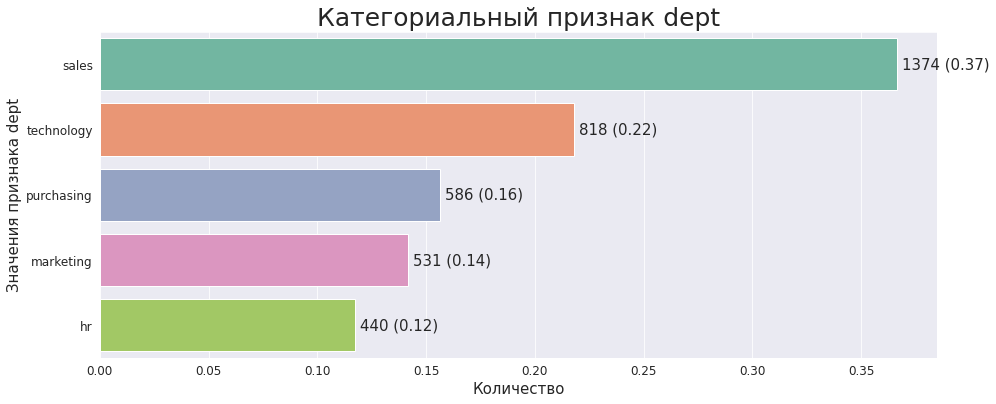

In [23]:
cat_analysis(data=train, cat='dept')

Видим, что тренировнчной выброке: на 1 месте `sales` с 1374 записями, на 2-ом `technology` c 818, на 3-ем `purchasing` - 586.

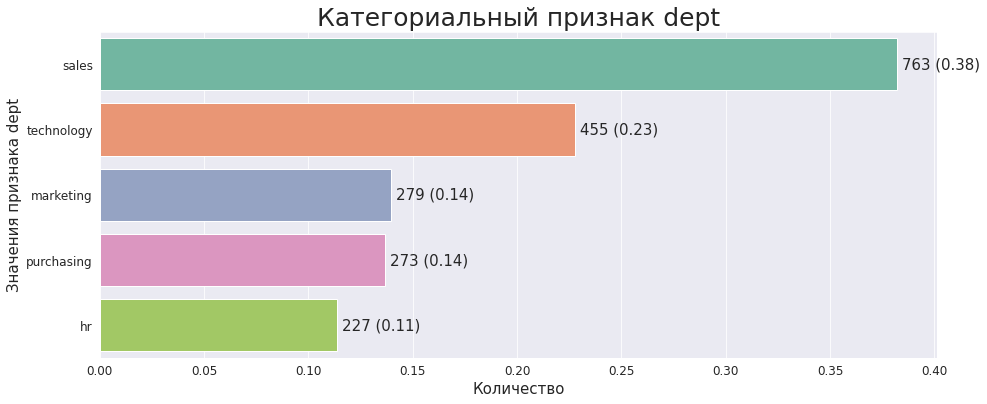

In [24]:
cat_analysis(data=test, cat='dept')

В тестовой выборке: на 1 месте `sales` с 766 записями, на 2-ом `technology` c 455, на 3-ем `marketing` - 279.

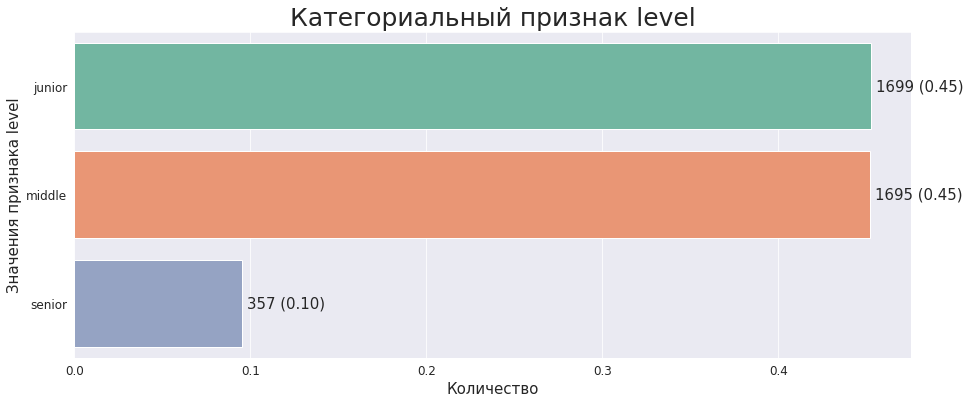

In [25]:
cat_analysis(data=train, cat='level')

Практически количество джунов и мидлов равно (1699 и 1695), сеньоров - 357.

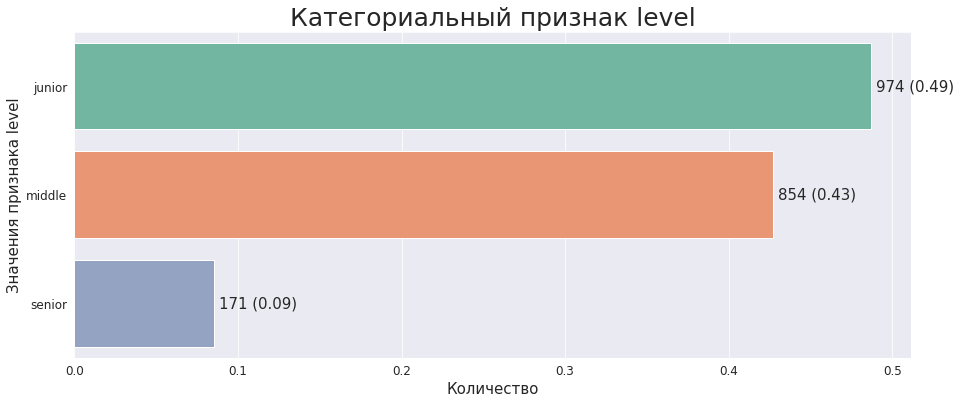

In [26]:
cat_analysis(data=test, cat='level')

Количество джунов составляет 974, мидлов - 854, сеньоров - 171.

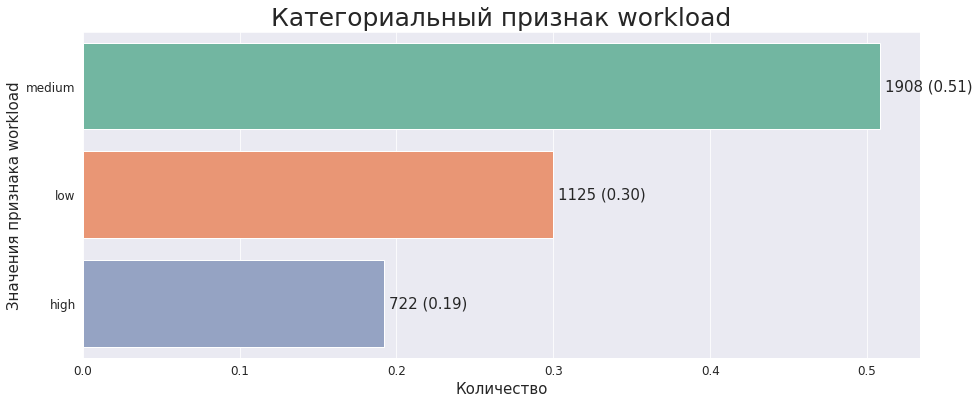

In [27]:
cat_analysis(data=train, cat='workload')

Загруженность в тренировночной выброке следующая:

- средняя степень загруженности у 1908 человек.
- низкая степень загруженности у 1125 человек.
- высокая степень загруженности у 722 человек.

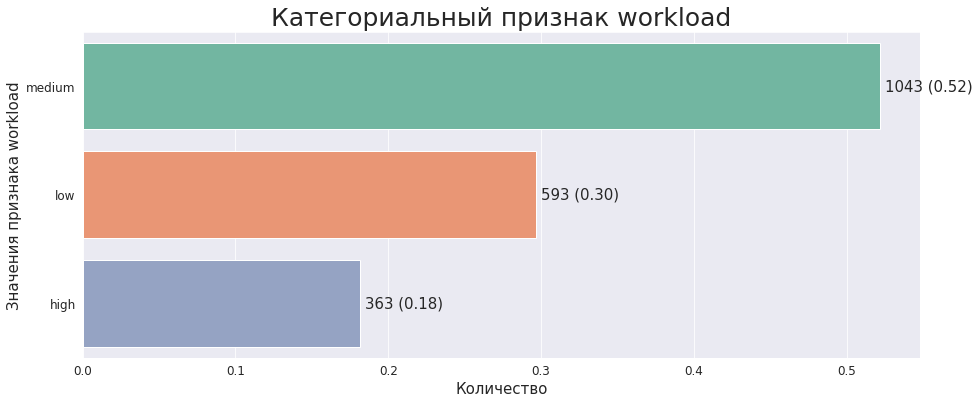

In [28]:
cat_analysis(data=test, cat='workload')

Загруженность в тестовой выброке следующая:

- средняя степень загруженности у 1043 человек.
- низкая степень загруженности у 593 человек.
- высокая степень загруженности у 363 человек.

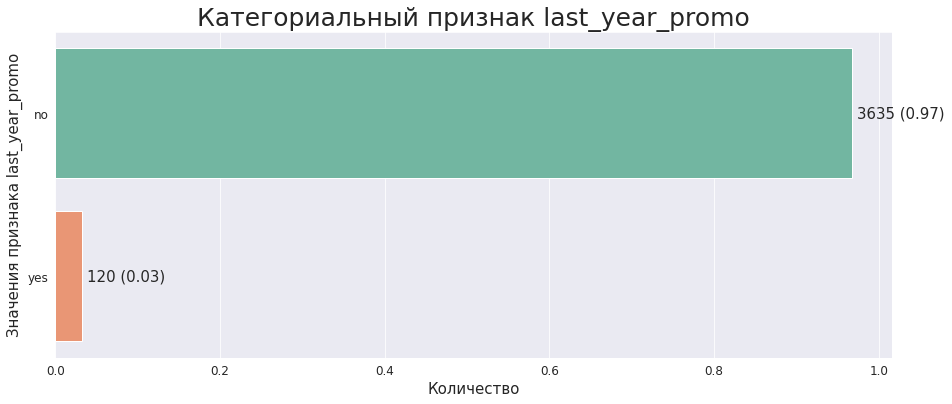

In [29]:
cat_analysis(data=train, cat='last_year_promo')

Повышение получили 120 человек, остальные остались на той же должности (3635).

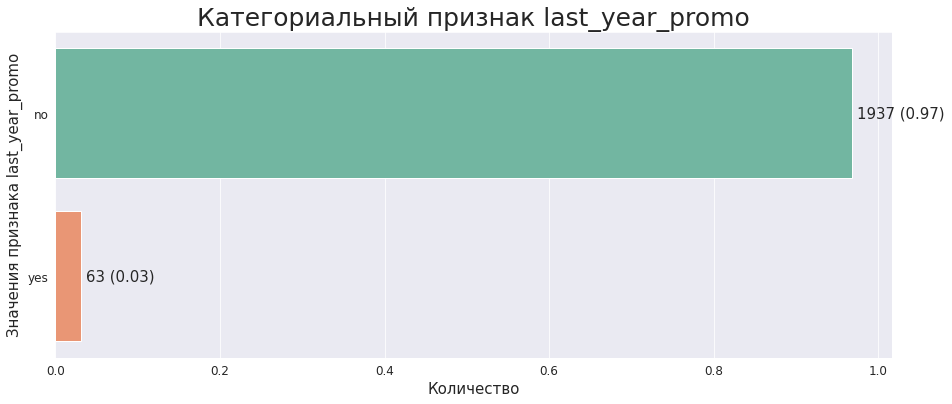

In [30]:
cat_analysis(data=test, cat='last_year_promo')

Повышение получили 65 человек, остальные остались на той же должности (1937).

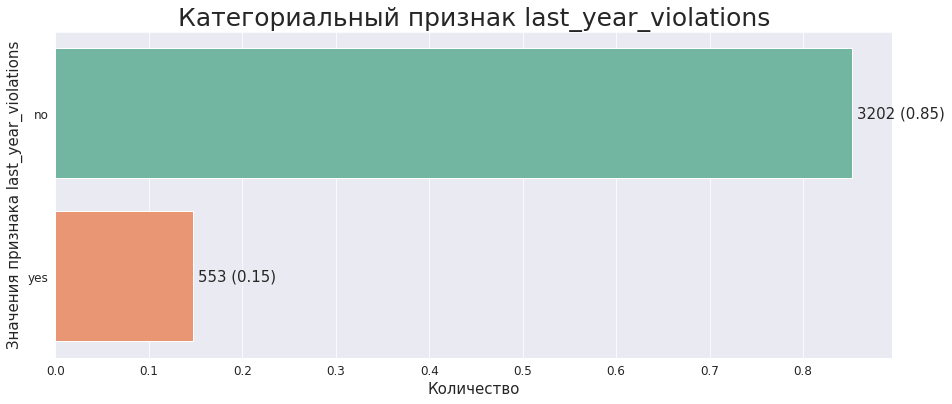

In [31]:
cat_analysis(data=train, cat='last_year_violations')

Нарушили трудовой договор 553 человека, остальные его нарушали (3202).

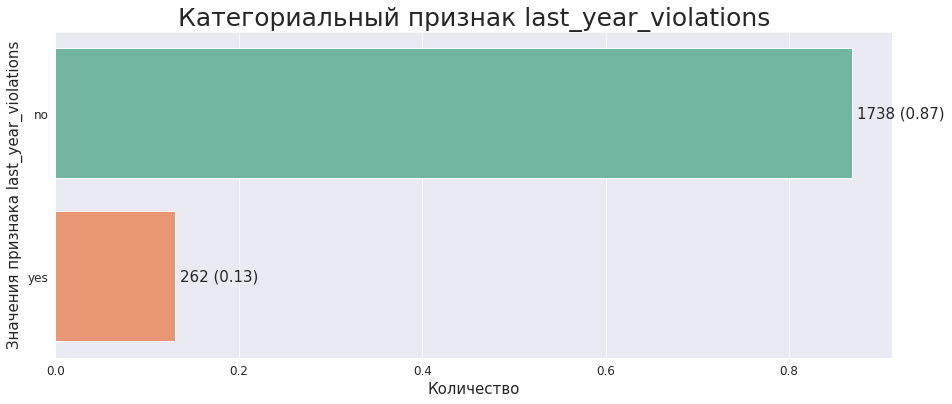

In [32]:
cat_analysis(data=test, cat='last_year_violations')

Нарушили трудовой договор 262 человека, остальные его нарушали (1738).

### Исследование количественных признаков <a id='132'></a>

Рассмотрим колличественные признаки в датасетах. Определим, являеются ли они нормальными с помощью критерия Шапиро-Уилка:

- H0: data['столбец с кол. знач.'] = N(μ, σ^2)
- H1: data['столбец с кол. знач.'] ≠ N(μ, σ^2)

Для кажого признака построим ящик с усами и гистограмму.

In [33]:
def num_analysis(data, num, bin_num=20, r=0):
    
    # num - исследуемый столбец с количественными значениями (обязателен)
    #data - исследуемый датасет
    # bin - число корзин
    # r - построение графиков для дискретных величин (строится при r=1)
    
      
    f, (ax_box, ax_hist) = plt.subplots(2, 
                                        sharex=True, 
                                        gridspec_kw={"height_ratios": (.15, .85)}, 
                                        figsize=(15, 6))

    sns.boxplot(x=data[num], ax=ax_box).set_title(f'Распределение {num}', fontsize=25);
        
    if r == 0:    
        sns.histplot(data=data, 
                     x=num, 
                     ax=ax_hist, 
                     bins=bin_num);
    else:
        
        value_counts = data[num].value_counts()
        relative_frequencies = data[num].value_counts(normalize=True)
        
        ax = sns.countplot(data=data, 
                           x=num,
                           order=value_counts.index);
        for i, (freq, count) in enumerate(zip(relative_frequencies, value_counts)):
            ax.annotate(f'{count} ({freq:.2f})', 
                        xy=(i, count), 
                        xytext=(0, 5), 
                        textcoords='offset points', 
                        ha='center',
                        fontsize=15)
    
    
    ax_box.set(xlabel='');
    plt.xlabel(f'Число {num}', fontsize=15);
    plt.ylabel('Частота', fontsize=15);

    
    plt.axvline(x=data[num].mean(), 
                color='g', 
                linestyle='-', 
                label=f'mean: {data[num].mean()}');
    plt.axvline(x=data[num].median(), 
                color='g', 
                linestyle='--', 
                label=f'median: {data[num].median()}');
        
    plt.legend();
        
    
    display(data[num].describe())
    print(shapiro(data[num]))

count   3755.00
mean       3.82
std        2.56
min        1.00
25%        2.00
50%        3.00
75%        6.00
max       10.00
Name: employment_years, dtype: float64

ShapiroResult(statistic=0.8949028849601746, pvalue=5.605193857299268e-45)


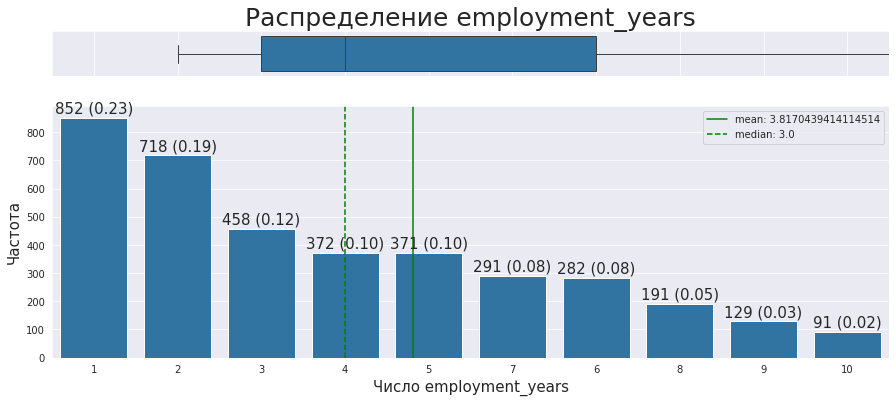

In [34]:
num_analysis(data=train, num='employment_years', r=1)

В тренировочной выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5). Посмотрим, сколько в среднем работают в разных отделах и в зависимости от уровня занимемой должности.

In [35]:
def num_cat_analysis(data, cat, num, hue=0):
    
    #data - выбираем датасет для исследования (обязателен)
    # cat - разделяем на категориальные группы (обязателен)
    # num - количетсвенный исследуемый признак (обязателен)
    # hue - разделяем на подгруппы
    
    
    plt.figure(figsize=(15, 6))
    if isinstance(hue, str):
        ax = sns.barplot(x=data[num], 
                         y=data[cat], 
                         data=data, 
                         hue=hue, 
                         errorbar=None, 
                         orient = 'h', 
                         palette='Set2',
                         legend=False)
        
        for container in ax.containers:
            ax.bar_label(container, fontsize=12, label_type='center')
            
            
        
    else:
        ax = sns.barplot(x=data[num], 
                         y=data[cat], 
                         data=data, 
                         errorbar=None, 
                         orient = 'h', 
                         palette='Set2', 
                         hue=data[cat], 
                         legend=False)

        for container in ax.containers:
            ax.bar_label(container, fontsize=12, label_type='center')
        
    
    plt.xlabel(f'Признак {num}',fontsize=15)
    plt.ylabel(f'Наименования в {cat}',fontsize=15)
    plt.title(f'Количественный признак {num} по {cat}', fontsize=25)

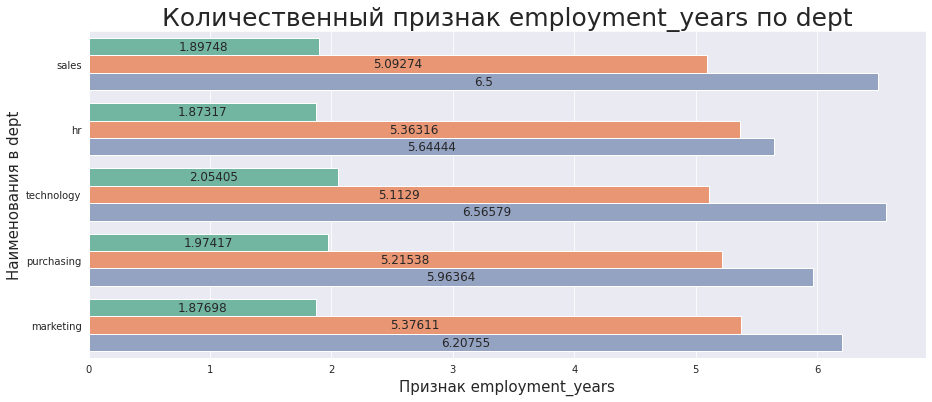

In [36]:
num_cat_analysis(data=train, cat='dept', num='employment_years', hue='level')

Видим, что в среднем все +/- имеют одинаковый трудовой стаж в компании «Работа с заботой». Больше всего лет работают в отделе `technology`.

count   2000.00
mean       3.67
std        2.54
min        1.00
25%        1.00
50%        3.00
75%        6.00
max       10.00
Name: employment_years, dtype: float64

ShapiroResult(statistic=0.8824772834777832, pvalue=1.7712498684843336e-36)


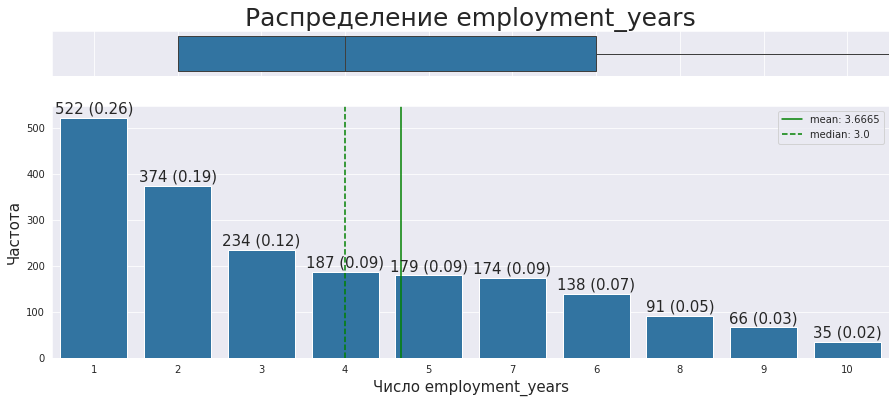

In [37]:
num_analysis(data=test, num='employment_years', r=1)

В тестовой выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5).

count   3755.00
mean       3.46
std        1.03
min        1.00
25%        3.00
50%        4.00
75%        4.00
max        5.00
Name: supervisor_evaluation, dtype: float64

ShapiroResult(statistic=0.8902250528335571, pvalue=1.401298464324817e-45)


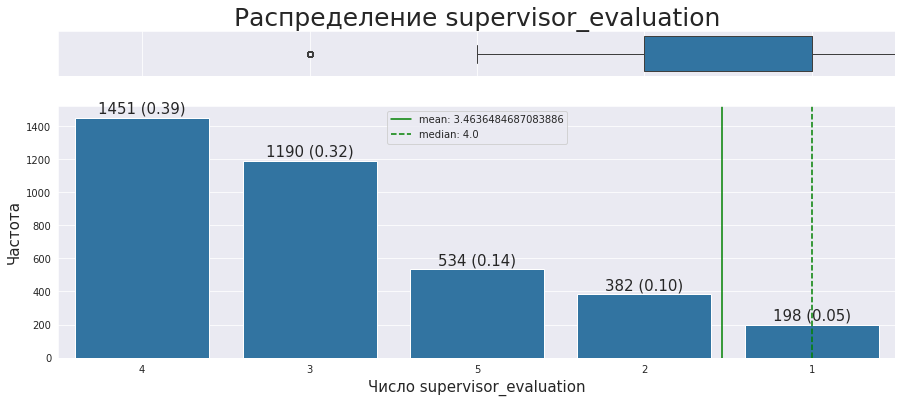

In [38]:
num_analysis(data=train, num='supervisor_evaluation', r=1)

Средняя оценка качества работы сотрудников сотавляет 3.5 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5). Ящик с усами показывает выброс в районе 1. Его оставлемя, т.к. данное значение содержит информацию о 5-балльном рейтенге (от 1 до 5). Посмотрим, как распределена оценка руководителя в зависимости от того, нарушал ли сотрудник договор.

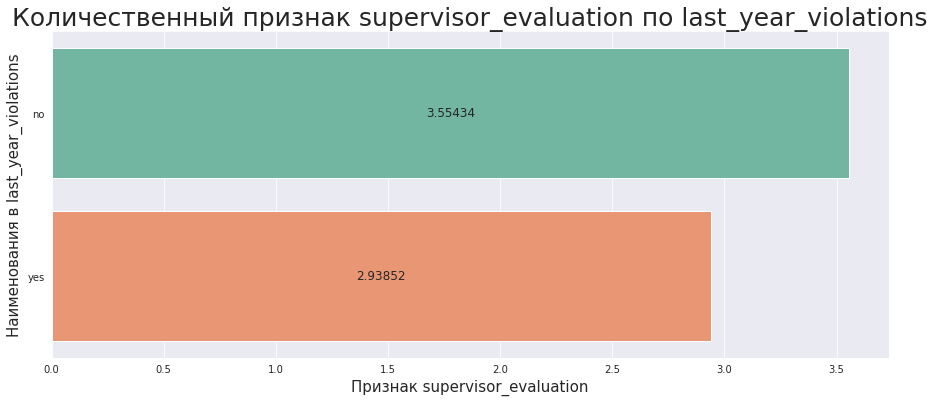

In [39]:
num_cat_analysis(data=train, cat='last_year_violations', num='supervisor_evaluation')

Те, кто нарушил договор, их оценка составляет 3 балла от руководителя, те кто не нарушал 3.6.

count   2000.00
mean       3.53
std        1.00
min        1.00
25%        3.00
50%        4.00
75%        4.00
max        5.00
Name: supervisor_evaluation, dtype: float64

ShapiroResult(statistic=0.8804605007171631, pvalue=1.0240325063892793e-36)


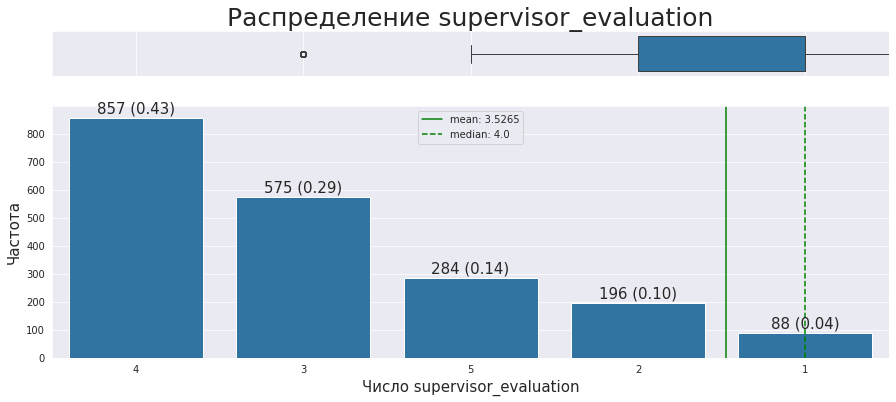

In [40]:
num_analysis(data=test, num='supervisor_evaluation', r=1)

Средняя оценка качества работы сотрудников сотавляет 3.5 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5).

count    3755.00
mean    34457.42
std     15050.64
min     12000.00
25%     22800.00
50%     31200.00
75%     44400.00
max     98400.00
Name: salary, dtype: float64

ShapiroResult(statistic=0.9424397945404053, pvalue=5.957610780143525e-36)


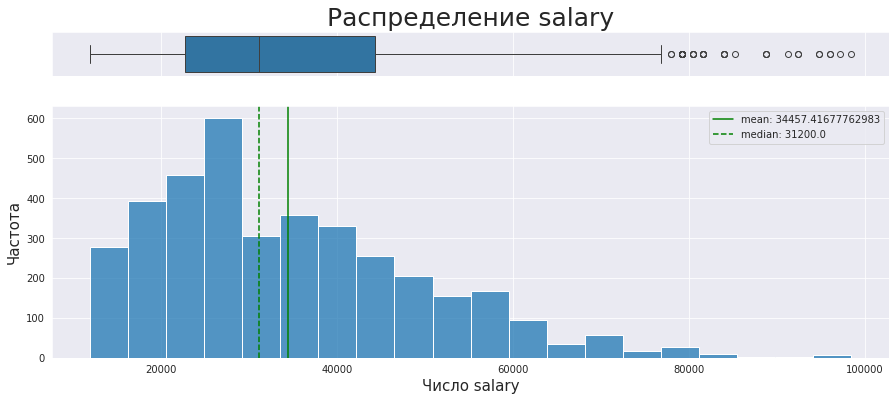

In [41]:
num_analysis(data=train, num='salary')

Средняя зарплата по комании составляет около 34500. Имеет смысл посмотреть в другом срезе, т.к. достаточно большой разброс от 12000 до 100000.  `salary` -  не распределено нормально (т.к. p-value < 0.5). 

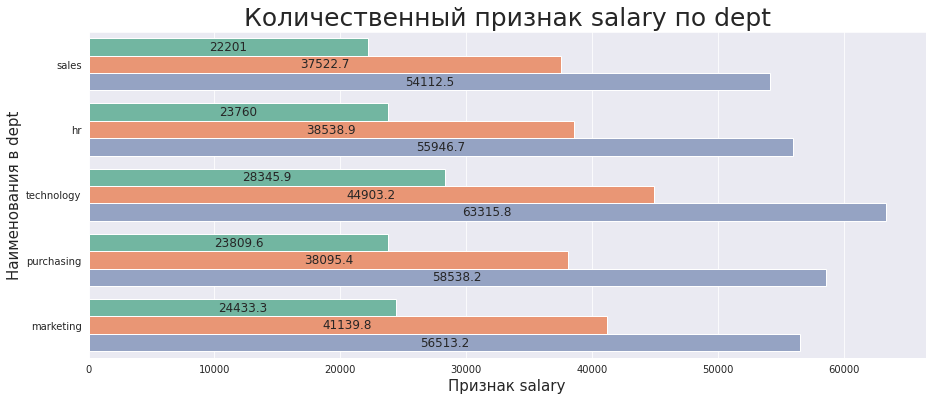

In [42]:
num_cat_analysis(data=train, cat='dept', num='salary', hue='level')

Видим, что высокие зарплаты в отделе `technolo`, в отделе `sales` - низкие.

count    2000.00
mean    34066.80
std     15398.44
min     12000.00
25%     22800.00
50%     30000.00
75%     43200.00
max     96000.00
Name: salary, dtype: float64

ShapiroResult(statistic=0.9255374073982239, pvalue=2.1315788254421244e-30)


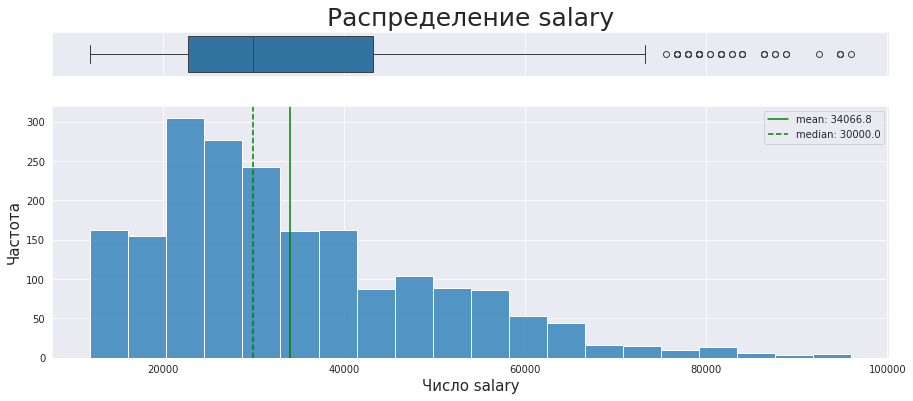

In [43]:
num_analysis(data=test, num='salary')

Видим, что здесь аналогичная ситуация, что и на предыдущем графике

count   3755.00
mean       0.53
std        0.23
min        0.03
25%        0.35
50%        0.55
75%        0.71
max        1.00
Name: job_satisfaction_rate, dtype: float64

ShapiroResult(statistic=0.9717873334884644, pvalue=1.3556486833817624e-26)


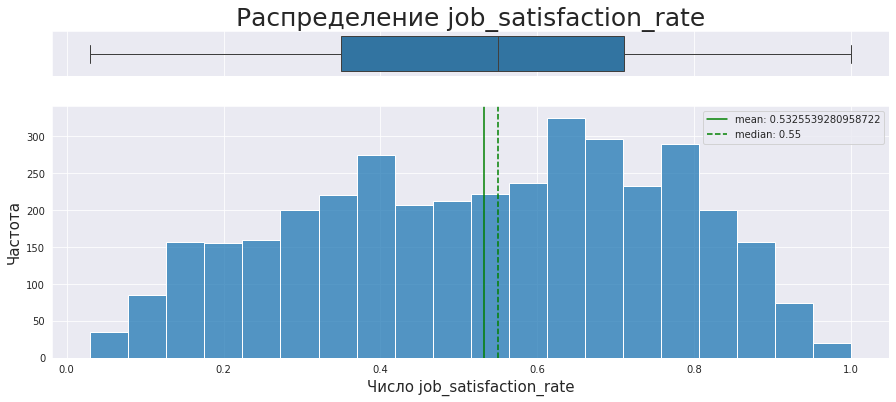

In [44]:
num_analysis(data=train, num='job_satisfaction_rate')

Средняя оценка удволетворенности сотрудников по компании составляет 0.5. Распределение ненорамльное, т.к p-value < 0.5. посмотрим, какую оценку ставят в зависимости от отдела.

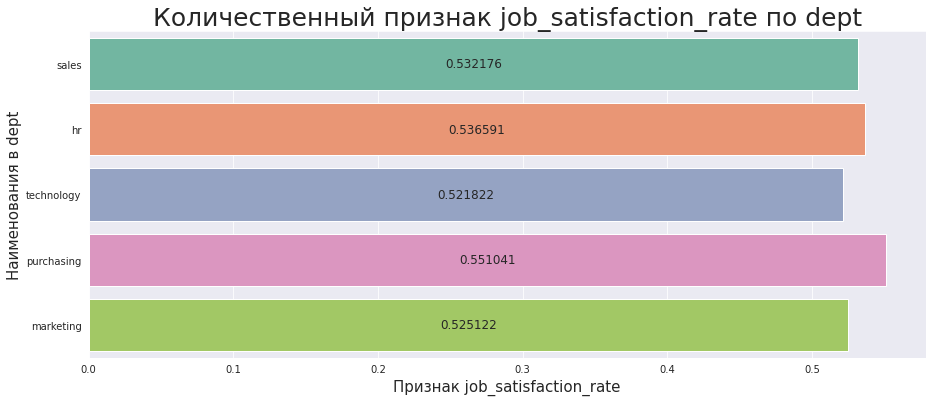

In [45]:
num_cat_analysis(data=train, cat='dept', num='job_satisfaction_rate')

Самую высокую оценку ставят из отдела закупок 0.55, низкая в техническом отделе  0.52.

count   2000.00
mean       0.55
std        0.22
min        0.03
25%        0.38
50%        0.58
75%        0.72
max        1.00
Name: job_satisfaction_rate, dtype: float64

ShapiroResult(statistic=0.969993531703949, pvalue=5.1222639213289125e-20)


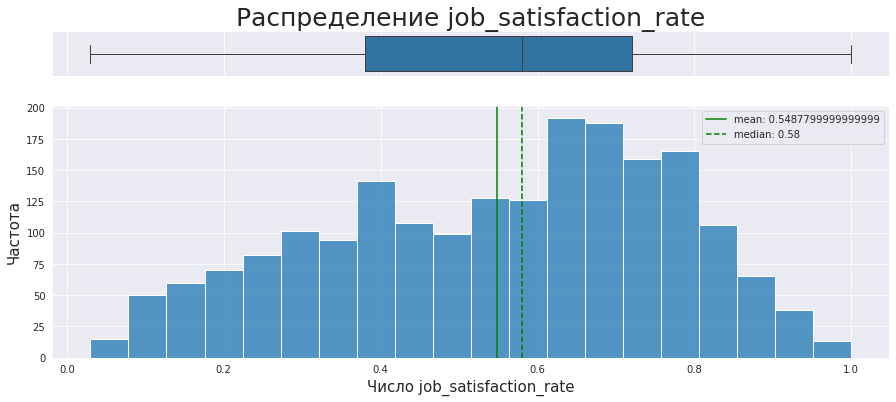

In [46]:
num_analysis(data=test, num='job_satisfaction_rate')

Средняя оценка удволетворенности сотрудников по компании составляет 0.55. Распределение ненорамльное, т.к p-value < 0.5. 

### Корреляционный анализ <a id='133'></a>

Теперь рассмотрим, как взаимосвязанны между собой признаки. Так как все признаки не распределены нормально будем использовать коэффицент корреляции Спирмена. Также посмотрим, рассмотрим степень связи для категориальных значений. Для этого воспользуемся `phik_matrix()` из библиотеки `phik`.

In [47]:
interval_cols = [ 'salary', 'job_satisfaction_rate']
corr_matrix = train.phik_matrix(interval_cols=interval_cols)

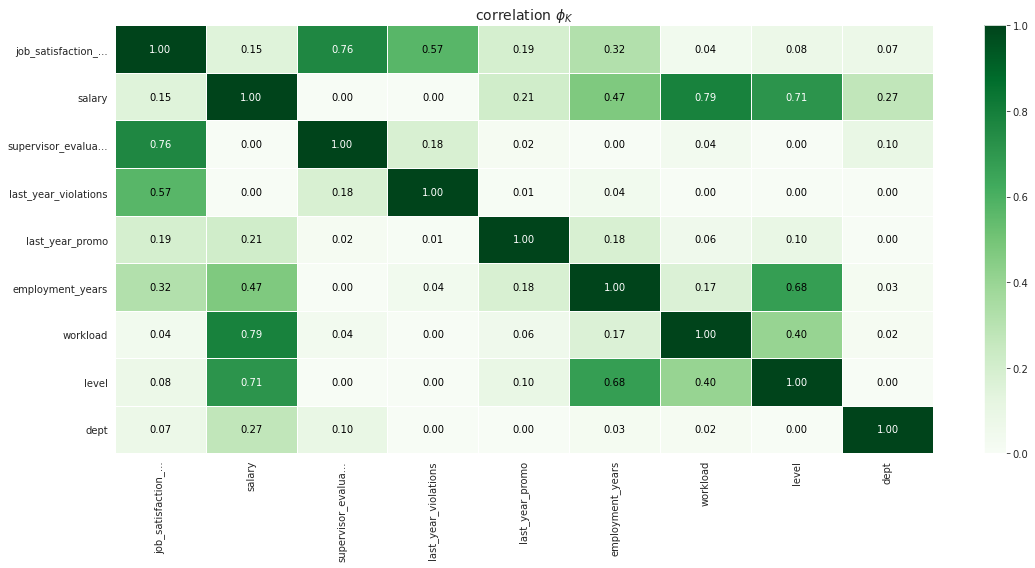

In [48]:
plot_correlation_matrix(corr_matrix.values, 
                        x_labels=corr_matrix.columns, 
                        y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(16, 8));
plt.tight_layout();

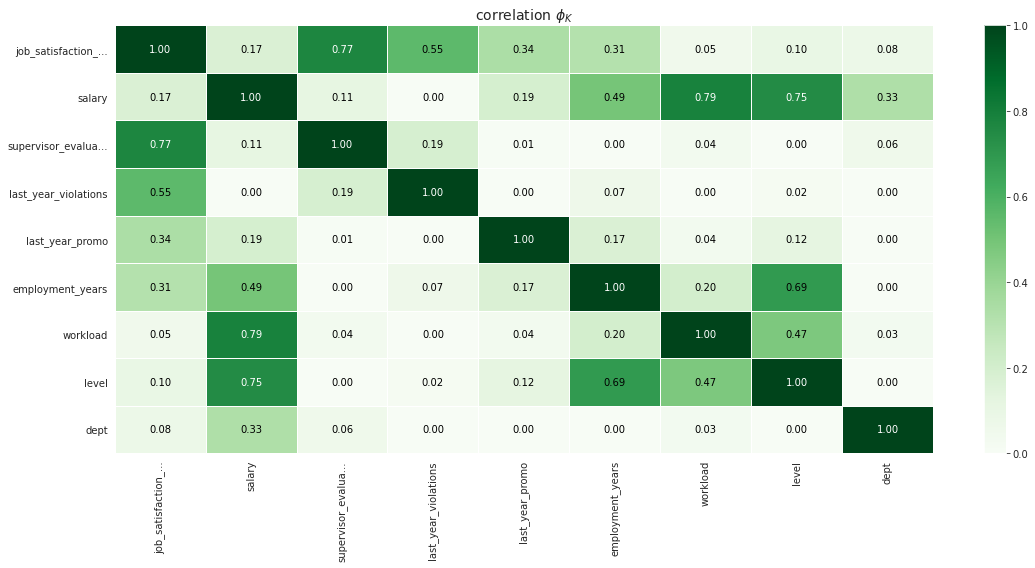

In [49]:
interval_cols = ['salary', 'job_satisfaction_rate']
corr_matrix = test.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(corr_matrix.values, 
                        x_labels=corr_matrix.columns, 
                        y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(16, 8));
plt.tight_layout();

Итак,

- Целевой признак `job_satisfaction_rate` (оценка сотрудников) имеет связь с `supervisor_evaluation` (оценка руководителя);
- `salary` (з.п.) с `workload` (степень загруженности) и `level` (уровень должности);
- `employment_years` (длительность работы) с `level` (уровень должности).
- Очень выссокая корреляции нет (0.9+), скорее всего, мультиколлинеарности нет.

Теперь посмотрим, какой тип связи имеют признаки.

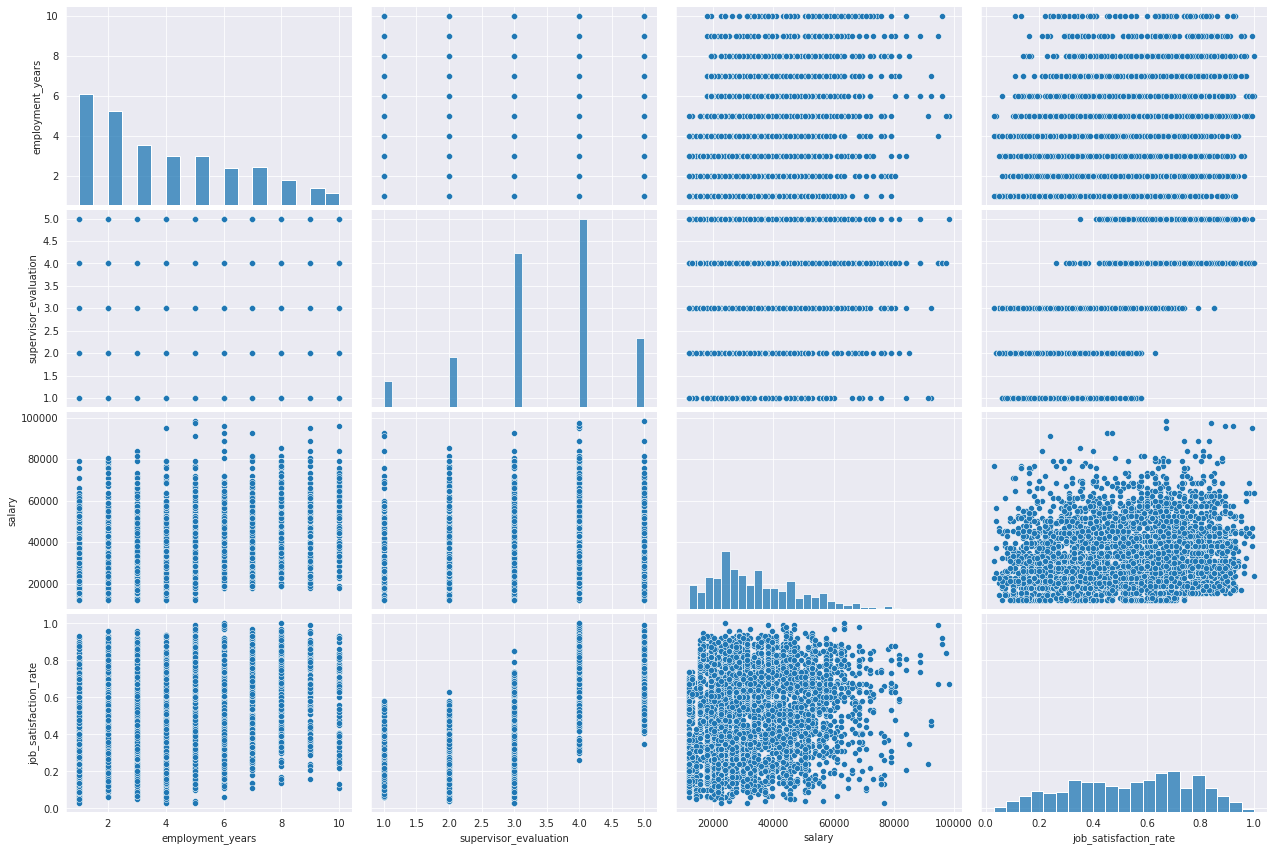

In [50]:
sns.pairplot(train, height=3, aspect=1.5);

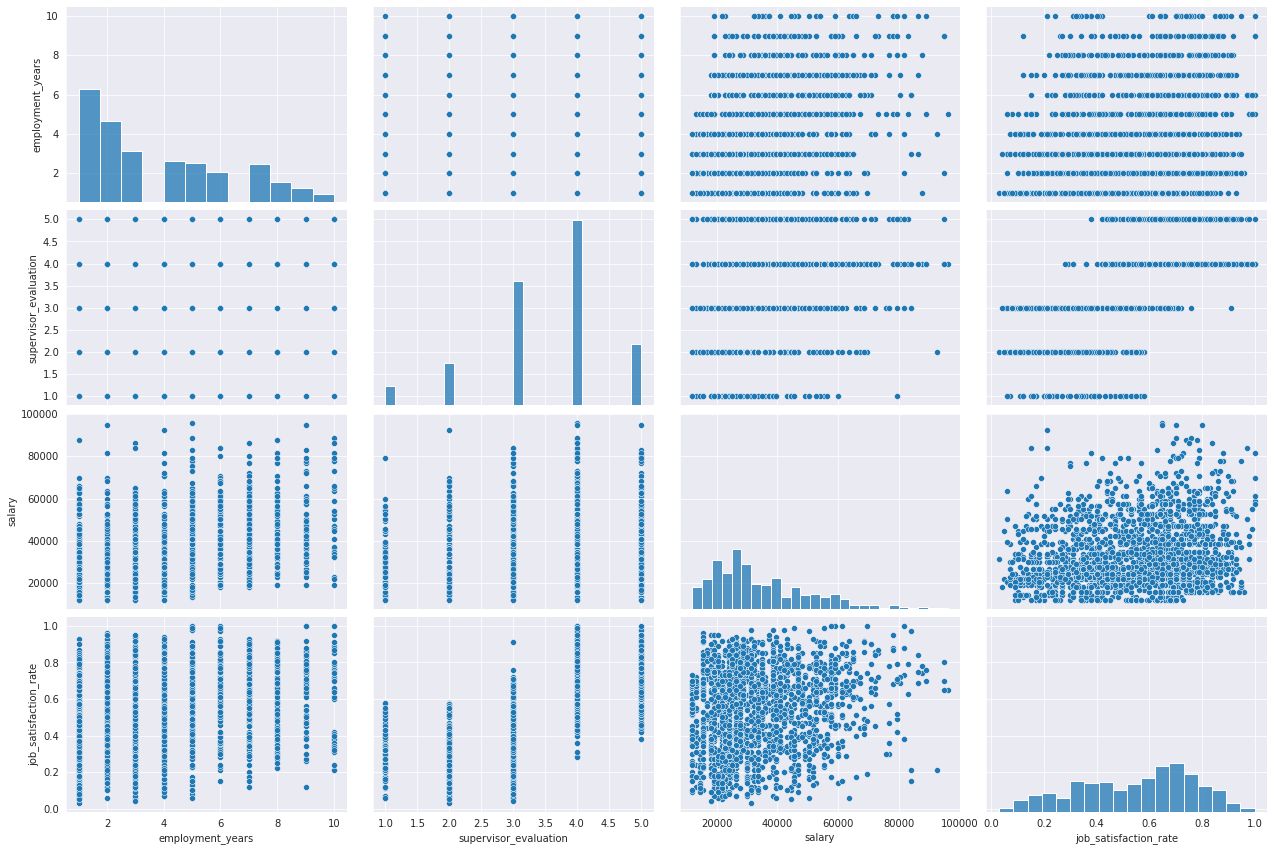

In [51]:
sns.pairplot(test, height=3, aspect=1.5);

- Видим, что признаки не между собой не имеют линейную связь.

### Вывод <a id='134'></a>

На данном шаге было исследованы категориальные и количественные признаки (одномерный анализ), а также корреляционный анализ (двумерный):

**Одномерный анализ**

`train`

- в тренировнчной выброке `dept`: на 1 месте `sales` с 1374 записями, на 2-ом `technology` c 818, на 3-ем `purchasing` - 586.
- Практически количество джунов и мидлов равно (1699 и 1695), сеньоров - 357 в `level`.

- Загруженность в тренировночной выброке `workload` следующая:

    - средняя степень загруженности у 1908 человек.
    - низкая степень загруженности у 1125 человек.
    - высокая степень загруженности у 722 человек.
    
- Повышение получили 120 человек, остальные остались на той же должности (3635) (`last_year_promo`).
- Нарушили трудовой договор 553 человека, остальные его нарушали (3202) (`last_year_violations`).
- В тренировочной выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5). В среднем все +/- имеют одинаковый трудовой стаж в компании «Работа с заботой». Больше всего лет работают в отделе `technology`.
- Средняя оценка качества работы сотрудников сотавляет 3.5 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5).
- Те, кто нарушил договор, их оценка составляет 3 балла от руководителя, те кто не нарушал 3.6.
- Средняя зарплата по комании составляет около 34500.  `salary` -  не распределено нормально (т.к. p-value < 0.5). Высокие зарплаты в отделе `technolo`, в отделе `sales` - низкие.
- Средняя оценка удволетворенности сотрудников по компании `job_satisfaction_rate` составляет 0.5. Распределение ненорамльное, т.к p-value < 0.5. Самую высокую оценку ставят из отдела закупок 0.55, низкая в техническом отделе  0.52.

`test`

- в тестовой выборке `dept`: на 1 месте `sales` с 766 записями, на 2-ом `technology` c 455, на 3-ем `marketing` - 279.
- Количество джунов составляет 974, мидлов - 854, сеньоров - 171 в `level`.
- Загруженность в тестовой выброке `workload` следующая:

    - средняя степень загруженности у 1043 человек.
    - низкая степень загруженности у 593 человек.
    - высокая степень загруженности у 363 человек.
    
- Повышение получили 65 человек, остальные остались на той же должности (1937) (`last_year_promo`).
- Нарушили трудовой договор 262 человека, остальные его нарушали (1738) (`last_year_violations`).
- В тестовой выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5).
- Средняя оценка качества работы сотрудников сотавляет 3.5 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5).
- Средняя зарплата по комании составляет около 34500.  `salary` -  не распределено нормально (т.к. p-value < 0.5).
- Средняя оценка удволетворенности сотрудников по компании (`job_satisfaction_rate`) составляет 0.6. Распределение ненорамльное, т.к p-value < 0.5.


**Двумерный анализ**

- Целевой признак `job_satisfaction_rate` (оценка сотрудников) имеет связь с `supervisor_evaluation` (оценка руководителя);
- `salary` (з.п.) с `workload` (степень загруженности) и `level` (уровень должности);
- `employment_years` (длительность работы) с `level` (уровень должности).
- Очень выссокая корреляции нет (0.9+), скорее всего, мультиколлинеарности нет.
- Видим, что признаки не между собой не имеют линейную связь.

## Подготовка данных <a id='14'></a>

### Подготовка пайплайна <a id='141'></a>

Для того, чтобы подготовить данные для модели нужны пайплайны. На шаге предобработке данных уже использовали 1 пайплайн, чтобы избавиться от пропусков в стобцах `dept`, `level` и `workload`. Эти столбцы уже закодированны. Осталось разобраться с оставшимеся: для категориальных применим кодировщик `OneHotEncoder()`, количественные признаки стандартизируем с помощью `StandardScaler()`.

Резделим данные на тестовый и тренировочные.

In [52]:
train.shape

(3755, 9)

In [53]:
test.shape

(2000, 9)

In [54]:
X_train = train.drop(['job_satisfaction_rate'], axis=1)
y_train = train['job_satisfaction_rate']
X_test = test.drop(['job_satisfaction_rate'], axis=1)
y_test = test['job_satisfaction_rate']

Создадим списки с названиями оставшихся признаков.

In [55]:
ohe_columns = ['dept', 'last_year_promo', 'last_year_violations']
ord_columns = ['level', 'workload']
num_columns = ['employment_years', 'supervisor_evaluation', 'salary'] 

Создадим пайплайн для подготовки признаков из списка `ohe_columns`.

In [56]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
    )

Создадим пайплайн для подготовки признаков из списка `ord_columns`.

In [57]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                ], 
         handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))]) 

Создадим общий пайплайн для подготовки данных.

In [58]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('ord', ord_pipe, ord_columns),
     ('num', StandardScaler(), num_columns)
    ], 
    remainder='passthrough'
)

Cоздадим итоговый пайплайн.

In [59]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

### Вывод <a id='142'></a>

На данном шаге был подготовлен пайплайн для обучения модели.

## Обучение моделей <a id='15'></a>

Теперь нужно определиться с моделью обучения. Наши данные не имеют линейную связь и не распределены нормально. По задаче требуется взять модели:

- линейную модель: `LinearRegression()`
- дерево решений: `DecisionTreeRegressor()`

Используем метрику `SMAPE`, для выбора лучшей модели.

$ SAMPE = \frac{100}{n} \sum _{i=1} ^{n} \frac{|y _{i} - y _{i}  ^{-}|}{(|y _{i}| + |y _{i}  ^{-}|)/2} $

где:
- $y _{i}$ — фактическое значение целевого признака для объекта с порядковым номером $i$ в выборке;
- $y _{i}  ^{-} $ — предсказанное значение целевого признака для объекта с порядковым номером $i$ в выборке;
- $n$ — количество объектов в выборке;
- $\sum _{i=1} ^{n} $  — сумма значений, полученная в результате операций, которые следуют за этим знаком, для всех объектов с порядковым номером от $i$ до $n$ в выборке.

### Метрика SAMPE <a id='151'></a>

Напишем функцию для метрики SAMPE.

In [60]:
def smape(y_test, y_pred):
    error = np.abs(y_test - y_pred)
    scale = (np.abs(y_test) + np.abs(y_pred)) / 2
    return np.mean(error / scale) * 100

Создадим пользовательскую метрику.

In [61]:
score_sampe = make_scorer(smape, greater_is_better=False) 

### Поиск лучшей модели для SAMPE <a id='152'></a>

Создадим словарь для перебора гипперпараметров.

In [62]:
param_grid = [
    

        # словарь для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [None] + [i for i in range(2, 7)],
        #'models__max_features': range(2, 5),
        'models__min_samples_split': range(2, 20),
        #'models__min_samples_leaf': range(2, 5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    
        # словарь для модели LinearRegression()
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
    
]

Используем метод оптимизации гиперпараметров модели `RandomizedSearchCV`.

In [63]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring=score_sampe,
    random_state=RANDOM_STATE,
    n_jobs=-1
)
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['dept',
                                                                                'last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pip...
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__min_samples_split': range(2, 20),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LinearRegression()],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42,
                   scoring=make_scorer(smape, greater_is_better=False, response_method='predict'))

In [64]:
print('Лучшая модель и её параметры:\n\n', randomized_search.best_estimator_)
print ('Метрика SAMPE лучшей модели на кросс-валидации:', abs(randomized_search.best_score_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['dept', 'last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                            

In [65]:
randomized_search.fit(X_train, y_train)
preds = randomized_search.predict(X_train)
print('Метрика SAMPE лучшей модели на тренировочной выборке:', smape(y_train, preds))

Метрика SAMPE лучшей модели на тренировочной выборке: 7.054303401746627


In [66]:
pred = randomized_search.predict(X_test)
print('Метрика SMAPE на тестовой выборке:', smape(y_test, pred))

Метрика SMAPE на тестовой выборке: 13.9347414613509


На тестовой выборке метрика SAMPE равно 13.93 (≤15).

In [67]:
pipe_dummy = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DummyRegressor())])

pipe_dummy.fit(X_train, y_train)

pred_dummy = pipe_dummy.predict(X_test)
print(f'Метрика SAMPE на тестовой выборке (константная модель): {smape(y_test, pred_dummy)}') 

Метрика SAMPE на тестовой выборке (константная модель): 38.26225790202237


### Вывод <a id='153'></a>

На данном шаге была создана пользовательская метрика SAMPE, и обучены 2 модели `LinearRegression()` и `DecisionTreeRegressor()`. 
На выходе получили, что древо решений оказалось лучшей моделью. 
- На этапе кросс-валидации метрика SAMPE составляет 15.24
- Для тестовой выброки SAMPE равно 13.93.
- Модель адекватна.

## Вывод по задачи 1 <a id='16'></a>

Итак, лучшая модель оказалась `DecisionTreeRegressor(max_depth=16, min_samples_split=13, random_state=42)`.

Почему так? Все из-за наших данных.

1. `DecisionTreeRegressor` может легко моделировать сложные нелинейные зависимости между признаками и целевой переменной.
2. Эта модель не требует предварительной нормализации данных или удаления множественных признаков, как это часто делается при использовании линейных моделей.

# Задача 2 Предсказание увольнения сотрудника из компании <a id='2'></a>

### Загрузить данные <a id='21'></a> <a id='211'></a>

Теперь перейдем ко 2 части исследования. Для начала нужно загрузить 2 датасета `train_quit.csv` и `test_target_quit.csv`

In [68]:
train_2 = pd.read_csv('/datasets/train_quit.csv')
test_features = pd.read_csv('/datasets/test_features.csv')
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')

### Проверить, что данные в таблицах соответствуют описанию <a id='212'></a>

In [69]:
info_df(train_2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


None

,id,employment_years,supervisor_evaluation,salary
count,4000.00,4000.00,4000.00,4000.00
mean,552099.28,3.70,3.47,33805.80
std,260158.03,2.54,1.00,15152.42
min,100222.00,1.00,1.00,12000.00
25%,327785.75,2.00,3.00,22800.00
50%,546673.00,3.00,4.00,30000.00
75%,781497.75,6.00,4.00,43200.00
max,999915.00,10.00,5.00,96000.00


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no
5,699916,sales,junior,low,1,no,yes,3,18000,yes
6,417070,technology,middle,medium,8,no,no,2,44400,no
7,165489,sales,middle,low,4,no,no,5,19200,no
8,996399,marketing,middle,low,7,no,no,4,25200,no
9,613206,technology,middle,medium,2,no,no,3,45600,yes


В датасете `train_2`:
- 4000 записей, пропуски отсутствуют;
- Типы значений соотвтсвуют сформированным выборкам;
- Описательная статистика для данного датасета выглядет вполне реалистичной;
- Названия столбцов не выбиваются из общей стилистики.

In [70]:
info_df(test_target_quit)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


None

,id
count,2000.00
mean,552765.21
std,253851.33
min,100298.00
25%,339052.00
50%,550793.00
75%,765763.75
max,999029.00


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes
5,223063,no
6,810370,no
7,998900,no
8,578329,no
9,648850,no


В датасете `test_target_quit`:
- 2000 записей, пропуски отсутствуют;
- Типы значений соотвтсвуют сформированным выборкам;
- Описательная статистика для данного датасета выглядет вполне реалистичной;
- Названия столбцов не выбиваются из общей стилистики.

### Вывод  <a id='213'></a>

- датасеты имеют разную длину: `train_2` -4000, `test_target_quit` - 2000.
- пропуски отсутствуют.
- описательная статистика у всех датасетов выглядет вполне реалистичной.
- названия столбцов не выбиваются из общей стилистики во всех датафреймах.
- Типы значений соотвтсвуют сформированным выборкам.
- С какими признаками нам предстоит работать:
    - `dept` - отдел - категориальный признак;
    - `level` - уровень должности - категориальный признак;
    -  `workload` - уровень загруженности сотрудника - категориальный признак;
    - `employment_years` - длительность работы в компании  - количественный признак;
    - `last_year_promo` - было ли повышение - категориальный признак;
    - `last_year_violations` - было ли нарушение со стороны сотрудника - категориальный признак;
    - `supervisor_evaluation` - оценка работы от руководителя (от 1 до 5 баллов) - количественный признак;
    - `salary` - зарплата - количетсвенный признак;
    - `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой (от 0.0 до 1);
    - `quit` — увольнение сотрудника из компании  - целевой количественный признак.

## Предобработка данных <a id='22'></a>

### Исследование явных дубликатов <a id='221'></a>

Рассмотрим наличие дубликатов в датасетах. Для начала назначим id-шники, далее посмотрим на количество дубликатов.

In [71]:
train_2.set_index('id', inplace = True)
test_features.set_index('id', inplace = True)
test_target_quit.set_index('id', inplace = True)
test_2 = test_features.merge(test_target_quit, right_index=True, left_index=True)

In [72]:
df = {
        'train_2': train_2,
        'test_2': test_2,
       }

In [73]:
for n, _ in df.items():
    print(f'Дубликаты в {n}', _.duplicated().sum())
    print(f'В процентом соотношение от общига числа:', round((_.duplicated().sum() / len(_)), 2) * 100, f'%')

Дубликаты в train_2 1413
В процентом соотношение от общига числа: 35.0 %
Дубликаты в test_2 504
В процентом соотношение от общига числа: 25.0 %


Видим, что в тренировочной выброке присутствуют дубликаты, всего их 35% от общего числа строк. Конечно, их много, но при обучение модели, они будут искажать данные.

In [74]:
train_2 = train_2.drop_duplicates()

Теперь дубликаты в тренировочной выброке отсутствуют.

### Проверка уникальных значения в столбцах <a id='222'></a>

In [75]:
for n, _ in df.items():
    for i in _.select_dtypes(exclude='number').columns.tolist():
        print(f'В датасете {n} столбец {i} присутствуют следующие уникальные значения')
        print('*' * 100)
        print(_[i].value_counts())

В датасете train_2 столбец dept присутствуют следующие уникальные значения
****************************************************************************************************
sales         1438
technology     928
purchasing     588
marketing      582
hr             464
Name: dept, dtype: int64
В датасете train_2 столбец level присутствуют следующие уникальные значения
****************************************************************************************************
junior    1949
middle    1694
sinior     357
Name: level, dtype: int64
В датасете train_2 столбец workload присутствуют следующие уникальные значения
****************************************************************************************************
medium    2118
low       1208
high       674
Name: workload, dtype: int64
В датасете train_2 столбец last_year_promo присутствуют следующие уникальные значения
****************************************************************************************************
no     3887
yes

Видим, что аналогично в данных нужно исправить значение `sinior` на `senior` в `level`.

In [76]:
train_2['level'] = train_2['level'].str.replace('sinior', 'senior')
test_2['level'] = test_2['level'].str.replace('sinior', 'senior')

/tmp/ipykernel_121/4025927258.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['level'] = train_2['level'].str.replace('sinior', 'senior')


Также заменим `' '` на `NaN`.

In [77]:
test_2['dept'] = test_2['dept'].replace(' ', np.nan)
test_2['workload'] = test_2['workload'].replace(' ', np.nan)

Также можем закодировать целевой признак в тестовом и тренировочном датасете.

In [78]:
le = LabelEncoder()
train_2['quit'] = le.fit_transform(train_2['quit'])
test_2['quit'] = le.transform(test_2['quit'])

/tmp/ipykernel_121/833471787.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['quit'] = le.fit_transform(train_2['quit'])


### Вывод <a id='223'></a>

 - поиск явных дубликатов: после назначения id были выявлены дубликаты в тренировачно выброке `train_2` и они составляли 35% от общего числа записей. Эти строки были удалены.
 - проверка уникальных значений: в датасетах было неправильно записано значение `senior` в столбце `level`. Заменили `' '` на `NaN`.
 - также закодировали целевой признак в тренировочных и тестовых датасетах с помощью `LabelEncoder()`.

## Исследовательский анализ данных <a id='23'></a>

### Исследование категориальных признаков <a id='231'></a>

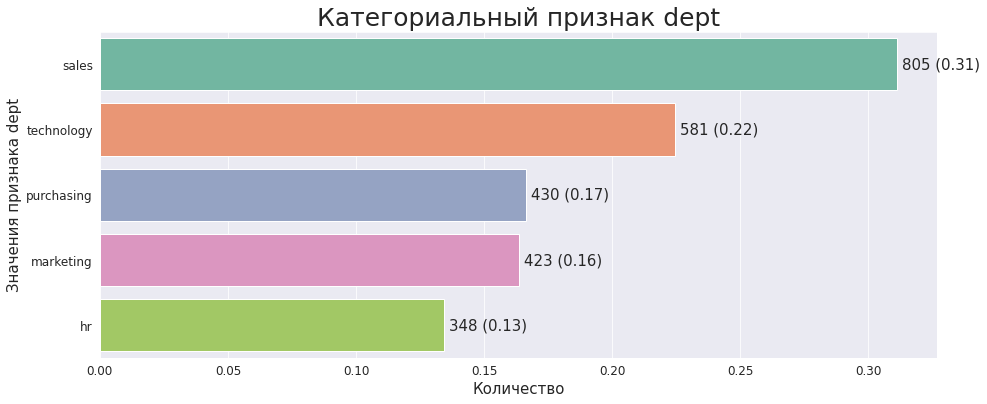

In [79]:
cat_analysis(data=train_2, cat='dept')

Видим, что тренировнчной выброке: на 1 месте `sales` с 805 записями, на 2-ом `technology` c 581, на 3-ем `purchasing` - 430.

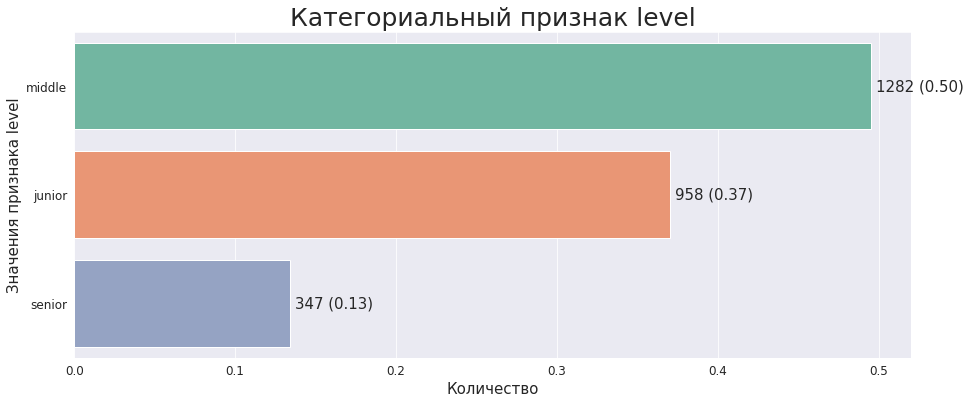

In [80]:
cat_analysis(data=train_2, cat='level')

Количество джунов составляет 1282, мидлов - 958, сеньоров - 347.

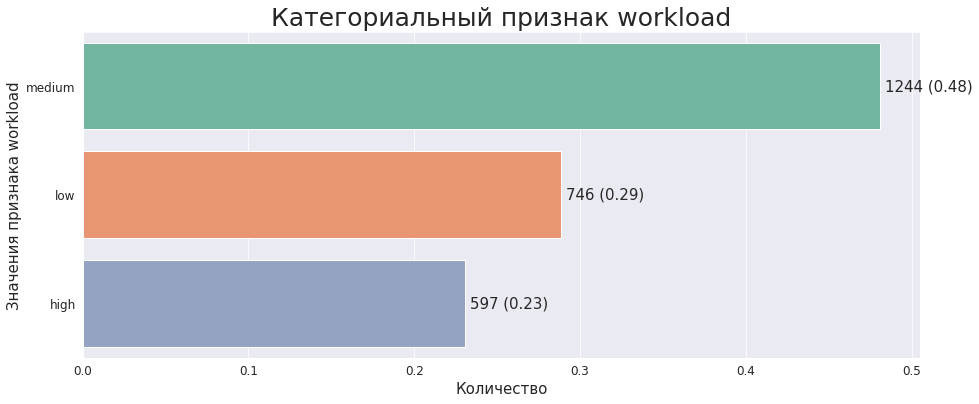

In [81]:
cat_analysis(data=train_2, cat='workload')

Загруженность выброке следующая:

- средняя степень загруженности у 1244 человек.
- низкая степень загруженности у 746 человек.
- высокая степень загруженности у 597 человек.

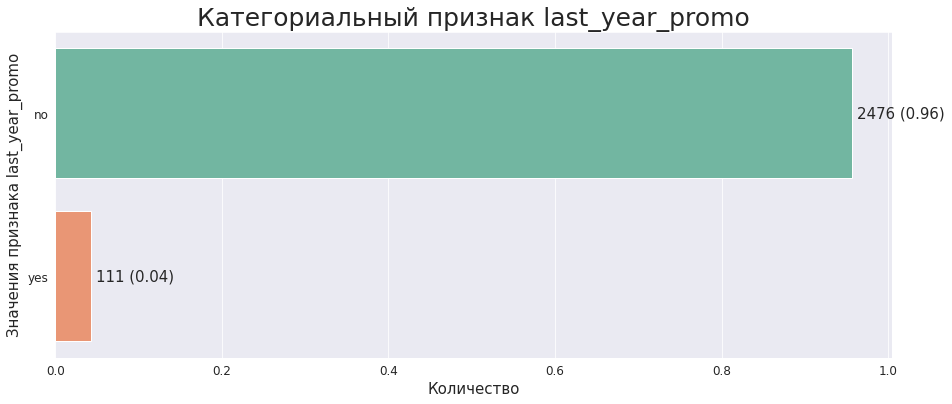

In [82]:
cat_analysis(data=train_2, cat='last_year_promo')

Повышение получили 111 человек, остальные остались на той же должности (2476).

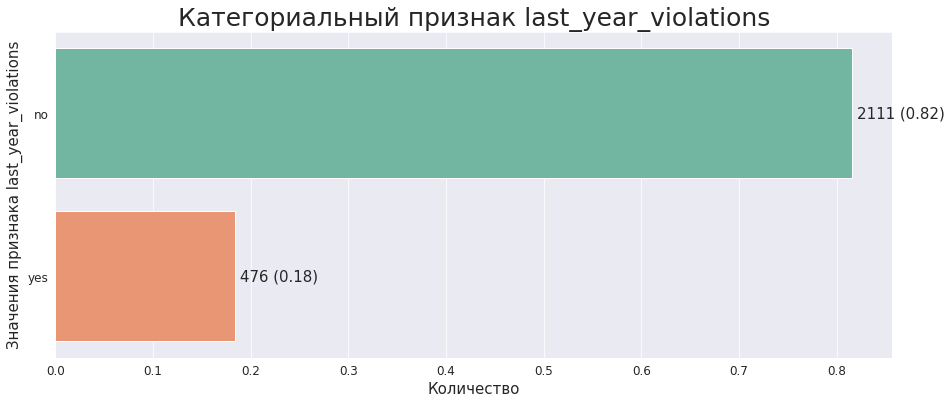

In [83]:
cat_analysis(data=train_2, cat='last_year_violations')

Нарушили трудовой договор 476 человека, остальные его нарушали (2111).

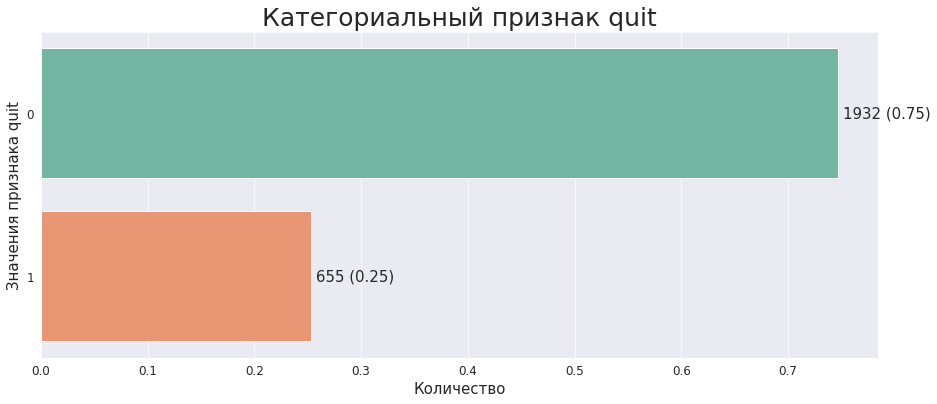

In [84]:
cat_analysis(data=train_2, cat='quit')

Видим, что тренировчной выброке количество уволившихся сотрудников составляет 655, те, кто в компании 1932. Виден дисбаланс у групп, его не получиться устранить, не нарушив закономерности данных

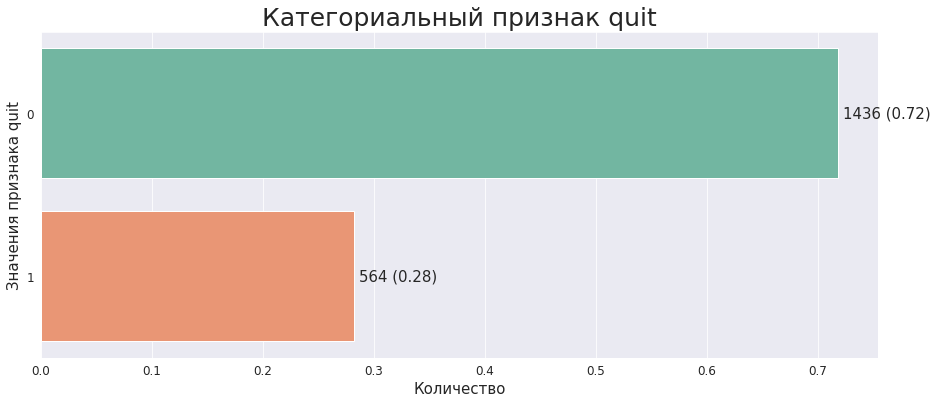

In [85]:
cat_analysis(data=test_2, cat='quit')

Видим, что в тестовой выброке количество уволившихся сотрудников составляет 564 человека (1), те, кто в компании 1436 (0).

### Исследование количественных признаков <a id='232'></a>

Рассмотрим колличественные признаки в датасетах. Определим, являеются ли они нормальными с помощью критерия Шапиро-Уилка:

- H0: data['столбец с кол. знач.'] = N(μ, σ^2)
- H1: data['столбец с кол. знач.'] ≠ N(μ, σ^2)

Для кажого признака построим ящик с усами и гистограмму.

count   2587.00
mean       4.21
std        2.60
min        1.00
25%        2.00
50%        4.00
75%        6.00
max       10.00
Name: employment_years, dtype: float64

ShapiroResult(statistic=0.9210703372955322, pvalue=8.05707131310746e-35)


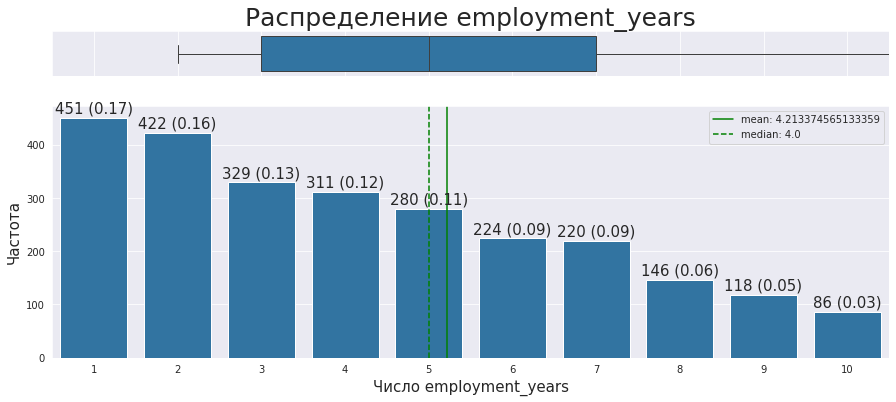

In [86]:
num_analysis(data=train_2, num='employment_years', r=1)

В тренировочной выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5).

count   2587.00
mean       3.37
std        1.08
min        1.00
25%        3.00
50%        3.00
75%        4.00
max        5.00
Name: supervisor_evaluation, dtype: float64

ShapiroResult(statistic=0.9018301367759705, pvalue=6.895760595934367e-38)


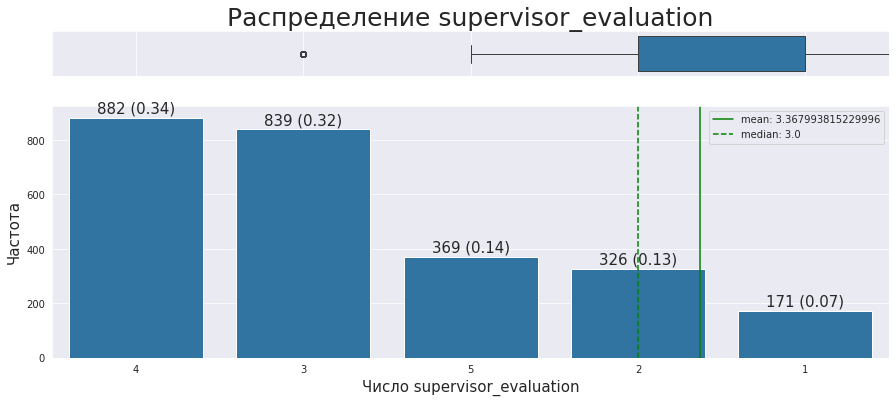

In [87]:
num_analysis(data=train_2, num='supervisor_evaluation', r=1)

Средняя оценка качества работы сотрудников сотавляет 3.4 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5). Ящик с усами показывает выброс в районе 1. Его оставлемя, т.к. данное значение содержит информацию о 5-балльном рейтенге (от 1 до 5). 

count    2587.00
mean    37107.69
std     16267.35
min     12000.00
25%     24000.00
50%     33600.00
75%     46800.00
max     96000.00
Name: salary, dtype: float64

ShapiroResult(statistic=0.9522790312767029, pvalue=2.925039566070898e-28)


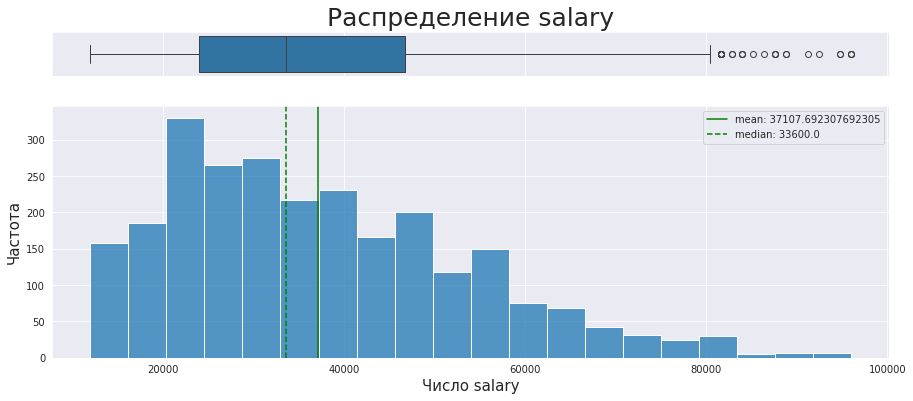

In [88]:
num_analysis(data=train_2, num='salary')

Средняя зарплата по комании составляет около 37000.  `salary` -  не распределено нормально (т.к. p-value < 0.5). 

### Портрет «уволившегося сотрудника» <a id='233'></a>

Теперь составим портрет «уволившегося сотрудника».

Посмотрим, количество уволившихся сотрудников по отделам.

In [89]:
yes = train_2.query('quit == 1')
no  = train_2.query('quit == 0')

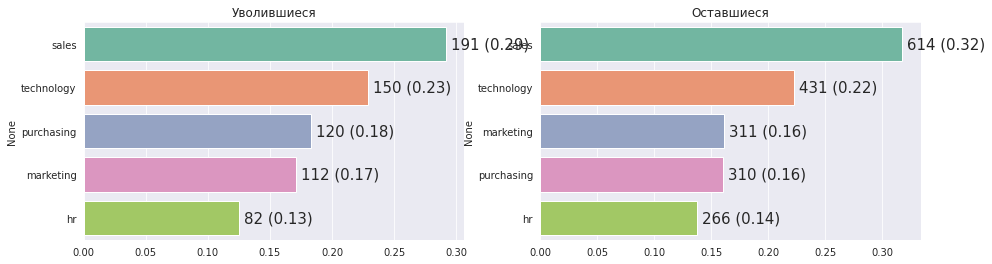

In [90]:
fig, axes  = plt.subplots(1, 2, figsize=(15, 4))

cat_analysis(data=yes, cat='dept', ax=axes[0], titel='Уволившиеся')

cat_analysis(data=no, cat='dept', ax=axes[1], titel='Оставшиеся')

Видим, что больше всего уволившихся сотрудников принадлежит к отделу продаж. Распределение уволившихся и оставшихся сотрудников по отделам примерно одинаково, поэтому нет смысла искать причину уволения в определенном отделе.

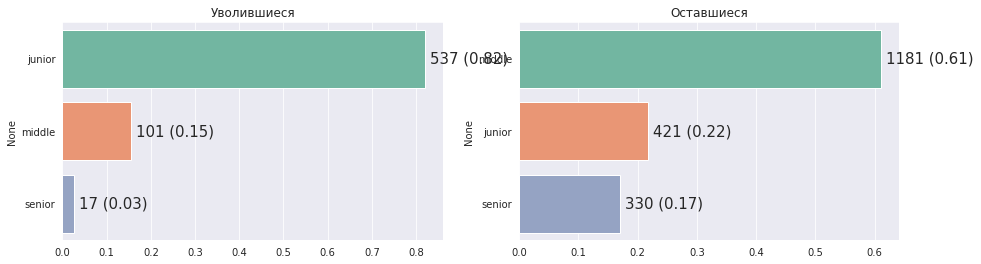

In [91]:
fig, axes  = plt.subplots(1, 2, figsize=(15, 4))

cat_analysis(data=yes, cat='level', ax=axes[0], titel='Уволившиеся')

cat_analysis(data=no, cat='level', ax=axes[1], titel='Оставшиеся')

Большинство уволилось с уровнем `junior`.

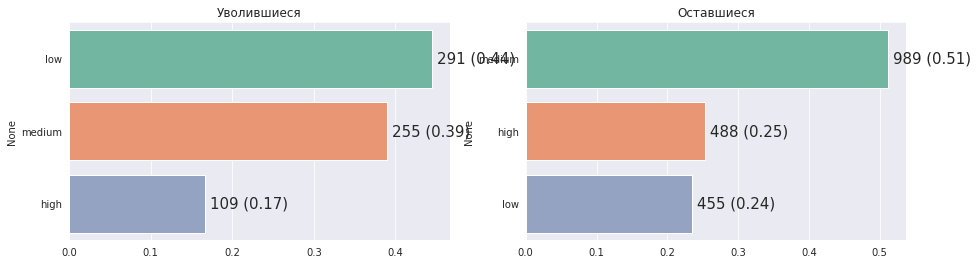

In [92]:
fig, axes  = plt.subplots(1, 2, figsize=(15, 4))

cat_analysis(data=yes, cat='workload', ax=axes[0], titel='Уволившиеся')

cat_analysis(data=no, cat='workload', ax=axes[1], titel='Оставшиеся')

Уволившиеся сотрудники в большинстве имели низкую нагрузку.

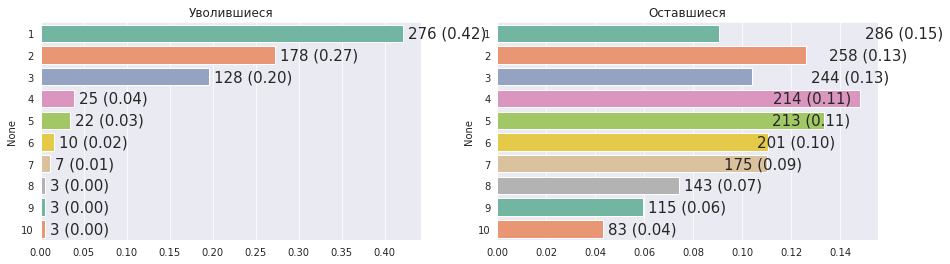

In [93]:
fig, axes  = plt.subplots(1, 2, figsize=(15, 4))

cat_analysis(data=yes, cat='employment_years', ax=axes[0], titel='Уволившиеся')

cat_analysis(data=no, cat='employment_years', ax=axes[1], titel='Оставшиеся')

Уволившийся сотрудник отработал 1 год в комании.

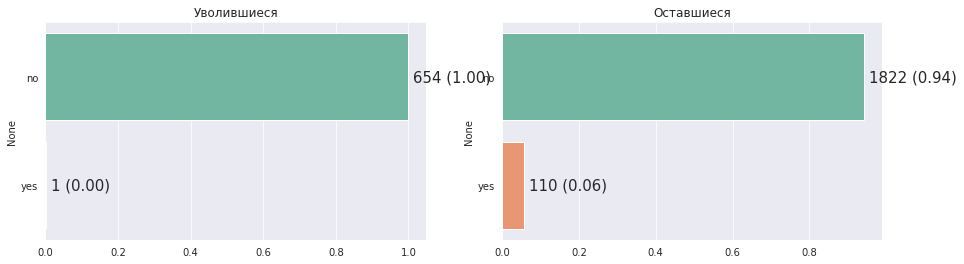

In [94]:
fig, axes  = plt.subplots(1, 2, figsize=(15, 4))

cat_analysis(data=yes, cat='last_year_promo', ax=axes[0], titel='Уволившиеся')

cat_analysis(data=no, cat='last_year_promo', ax=axes[1], titel='Оставшиеся')

Только 1 сотрудник уволился получивший повышение.

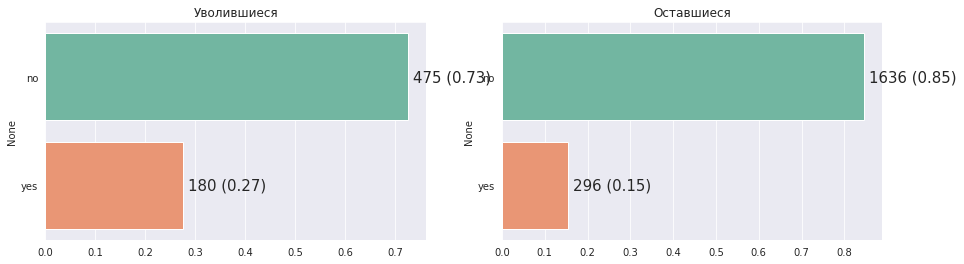

In [95]:
fig, axes  = plt.subplots(1, 2, figsize=(15, 4))

cat_analysis(data=yes, cat='last_year_violations', ax=axes[0], titel='Уволившиеся')

cat_analysis(data=no, cat='last_year_violations', ax=axes[1], titel='Оставшиеся')

В целом, 2 группы сотрудников не нарушали трудовой договор.

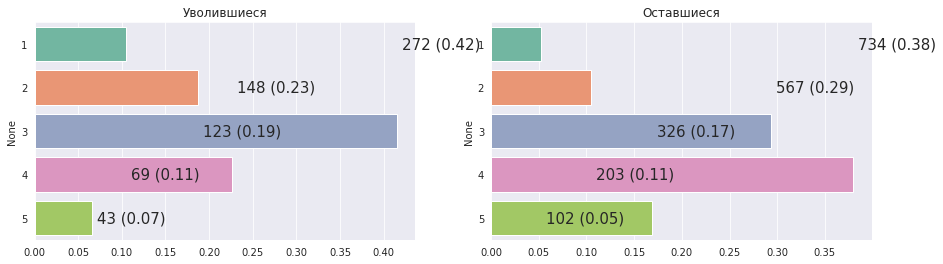

In [96]:
fig, axes  = plt.subplots(1, 2, figsize=(15, 4))

cat_analysis(data=yes, cat='supervisor_evaluation', ax=axes[0], titel='Уволившиеся')

cat_analysis(data=no, cat='supervisor_evaluation', ax=axes[1], titel='Оставшиеся')

Большинству уволившихся сотрудников руководитель ставил оценку 3, а оставшимся 4.

In [97]:
def yes_no_num(num, title):
    plt.figure(figsize=(15, 6))
    sns.histplot(data=no, 
                 x=no[num], 
                 bins=20, 
                 label='Работает',
                 stat='density',
                 common_norm=False);

    median_val = no[num].median()
    mean_val = no[num].mean()

    plt.axvline(x=mean_val, 
                color='b', 
                linestyle='-', 
                label=f'mean работают: {mean_val}'); 
    plt.axvline(x=median_val, 
                color='b', 
                linestyle='--', 
                label=f'median работают: {median_val}');


    sns.histplot(data=yes, 
                x=yes[num], 
                bins=20, 
                alpha= 0.7, 
                label='Уволился', 
                color='red',
                stat='density',
                common_norm=False);

    median_val = yes[num].median()
    mean_val = yes[num].mean()

    plt.axvline(x=yes[num].mean(), 
                color='r', linestyle='-', 
                label=f'mean уволился: {mean_val}');
    plt.axvline(x=yes[num].median(), 
                color='r', 
                linestyle='--',
                label=f'median уволился: {median_val}'); #, label=f'median: {yes['salary'].median()}'
        
    plt.xlabel(f'Зарплата', fontsize=15);
    plt.ylabel('Плотность распеделения', fontsize=15);
    plt.title(f'{title}', fontsize=25)
        
    plt.legend(loc='upper right');
    
    print('Сравнение средних 2 выборок', ttest_ind(yes[num], no[num]))

Сравнение средних 2 выборок Ttest_indResult(statistic=-22.585231086351452, pvalue=3.1324987177144555e-103)


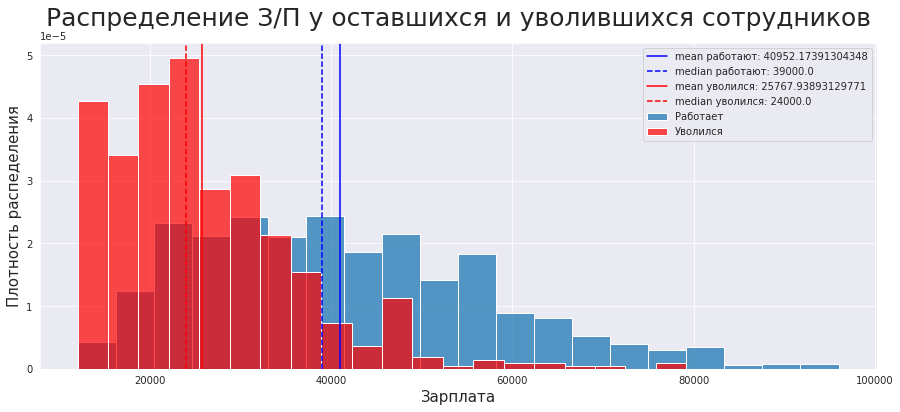

In [98]:
yes_no_num('salary', title='Распределение З/П у оставшихся и уволившихся сотрудников')

Видим, что у уволившихся сотрудников в основном низкая заработная плата, и среднее составляет около 26000.

### Анализ уровня удовлетворённости и уволнения <a id='234'></a>

Добавим признак `job_satisfaction_rate` из предыдущей задачи. После посмотрим, как распределены группы по этому признаку.

In [99]:
target = test_2.merge(test_target_job_satisfaction_rate, on= 'id', how= 'left')

yes = target.query('quit == 1')
no  = target.query('quit == 0')

Сравнение средних 2 выборок Ttest_indResult(statistic=-23.074784903634534, pvalue=1.231122066517193e-104)


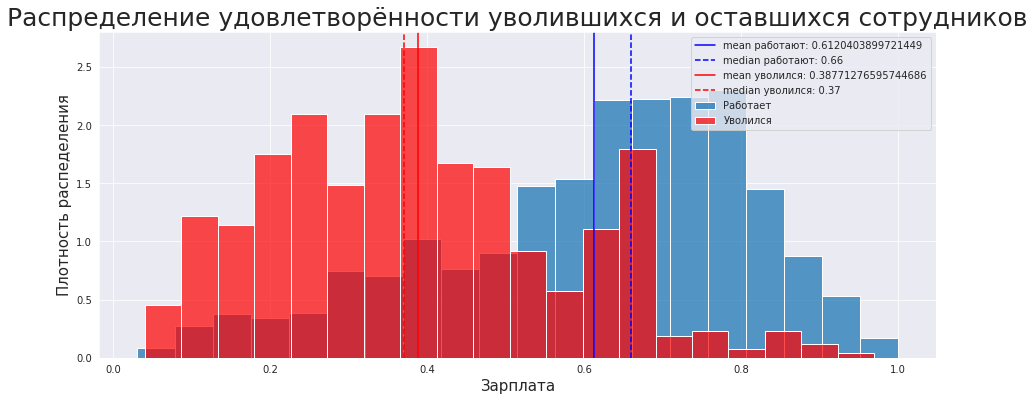

In [100]:
yes_no_num('job_satisfaction_rate', title='Распределение удовлетворённости уволившихся и оставшихся сотрудников')

На графике видно, что уволивишеся сотрудники не удволетворенны работой, в среднем их оценка составляет (0.4), те, кто в штате 0.61.

Сформируем гипотезу:
    
- Гипотеза (H0): Средние значения в выборках `yes` и `no` взяты из одного и того же распределения. 
    μ1 = μ2
    
- Альтернативная гипотеза (H1): Средние значения в выборках `yes` и `no` взяты из разных распределений.
    μ1 ≠ μ2
    
μ1 - среднее значение выборки `yes`,
    
μ2 - среднее значение выборки `no`.


Т-тест Стьюдента показал, что p-value=1.231122066517193e-104. Это говорит нам о том, что различия между группами являются статистически значимыми. 

### Корреляционный анализ <a id='235'></a>

Теперь рассмотрим, как взаимосвязанны между собой признаки. Так как все признаки не распределены нормально будем использовать коэффицент корреляции Спирмена.

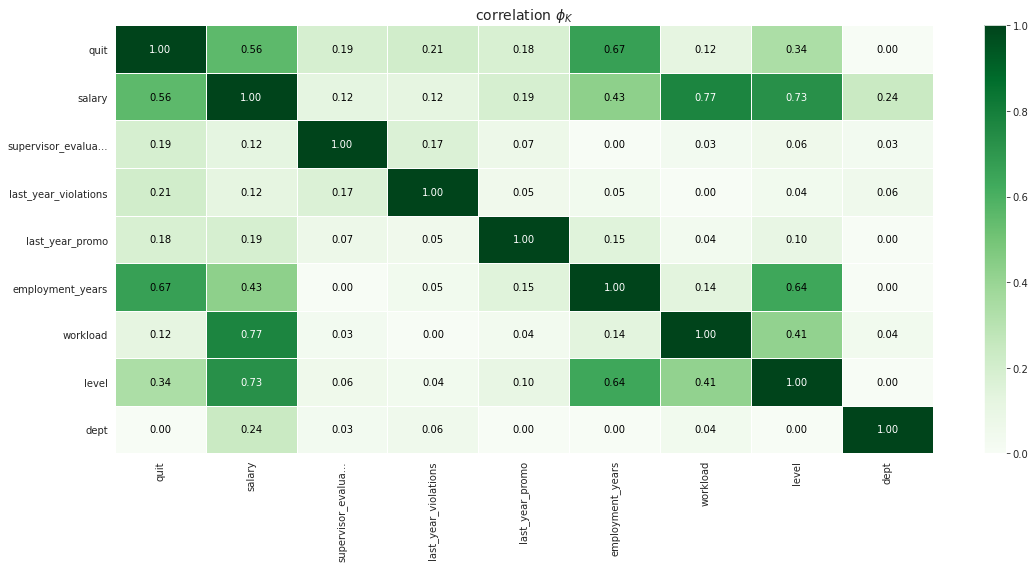

In [101]:
interval_cols = ['salary', 'job_satisfaction_rate']
corr_matrix = train_2.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(corr_matrix.values, 
                        x_labels=corr_matrix.columns, 
                        y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(16, 8));
plt.tight_layout();

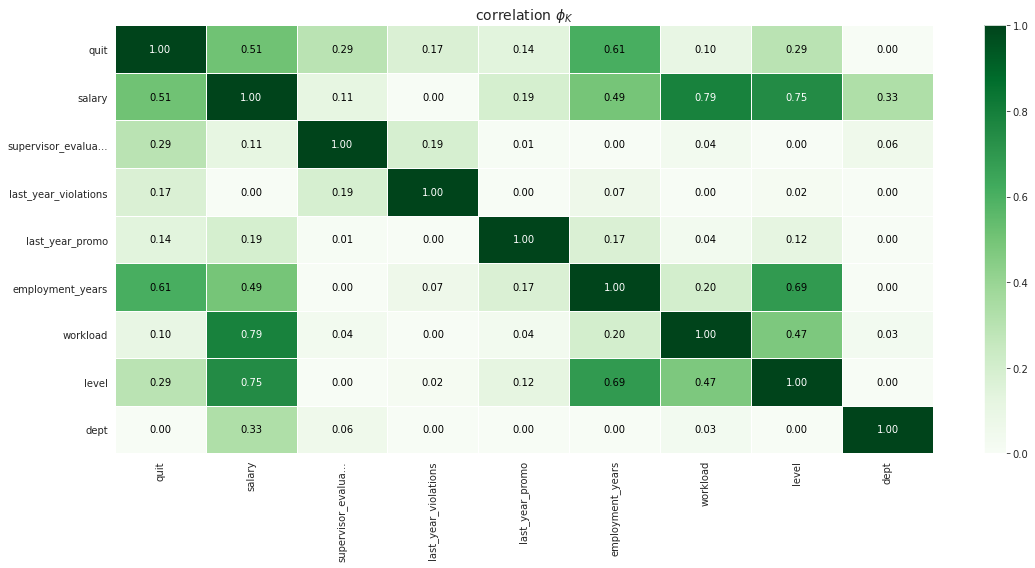

In [102]:
interval_cols = ['salary', 'job_satisfaction_rate']
corr_matrix = test_2.phik_matrix(interval_cols=interval_cols)

plot_correlation_matrix(corr_matrix.values, 
                        x_labels=corr_matrix.columns, 
                        y_labels=corr_matrix.index, 
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1, 
                        figsize=(16, 8));
plt.tight_layout();

Итак,

- Целевой признак `quit` (увольнение сотрудника) имеет связь с `employment_years` (оценка руководителя);
- `salary` (з.п.) с `workload` (степень загруженности) и `level` (уровень должности);
- `employment_years` (длительность работы) с `level` (уровень должности).
- Очень выссокая корреляции нет (0.9+), скорее всего, мультиколлинеарности нет.

Теперь посмотрим, какой тип связи имеют признаки.

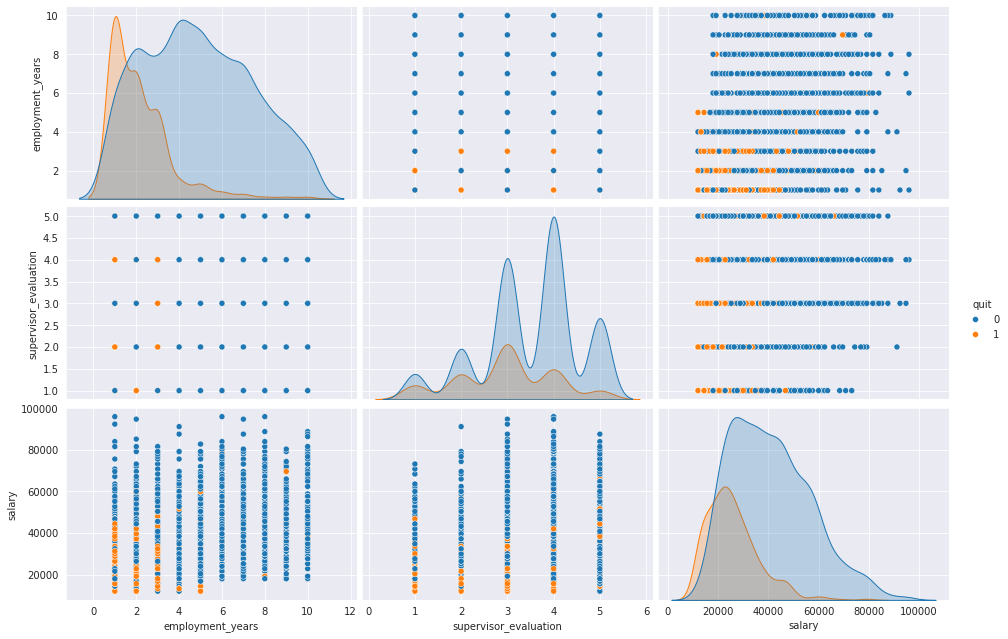

In [103]:
sns.pairplot(train_2, hue='quit', height=3, aspect=1.5);

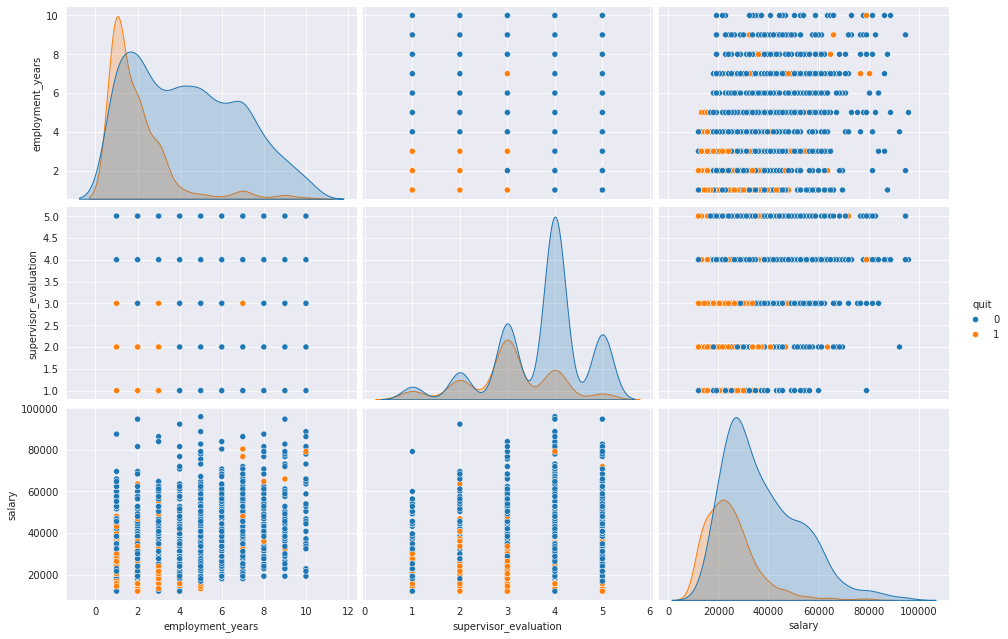

In [104]:
sns.pairplot(test_2, hue='quit', height=3, aspect=1.5);

- Видим, что признаки не между собой не имеют линейную связь.

### Вывод <a id='236'></a>

На данном этапе мы исследовали категориальные и колчественные значения (одномерный анализ) и провели корелляционный ананлиз (двумерный). Также составили портрет «уволившегося сотрудника»:

1. Одномерный анализ

**train_2**

- В тренировнчной выброке: на 1 месте `sales` с 805 записями, на 2-ом `technology` c 581, на 3-ем `purchasing` - 430. (`dept`).
- Количество джунов составляет 1282, мидлов - 958, сеньоров - 347. (`level`).
- Загруженность в выброке следующая (`workload`):

    - средняя степень загруженности у 1244 человек.
    - низкая степень загруженности у 746 человек.
    - высокая степень загруженности у 597 человек. 
    
- Повышение получили 111 человек, остальные остались на той же должности (2476). (`last_year_promo`).
- Нарушили трудовой договор 476 человека, остальные его нарушали (2111). (`last_year_violations`).
- Видим, что тренировчной выброке количество уволившихся сотрудников составляет 655, те, кто в компании 1932. Виден дисбаланс у групп, его не получиться устранить, не нарушив закономерности данных. (`quit`)
- В тренировочной выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5).
- Средняя оценка качества работы сотрудников сотавляет 3.4 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5). Ящик с усами показывает выброс в районе 1. Его оставлемя, т.к. данное значение содержит информацию о 5-балльном рейтенге (от 1 до 5).
- Средняя зарплата по комании составляет около 37000.  `salary` -  не распределено нормально (т.к. p-value < 0.5). 

**test_2**

- в тестовой выброке количество уволившихся сотрудников составляет 564 человека, те, кто в компании 1436. (`quit`)


**Портрет «уволившегося сотрудника»**

- сотрудник уровня junior;
- работал 1 год;
- имел низкую нагрузку на работе;
- не получал повышение;
- руководитель оценивает их на 3 балла;
- низкой з/п в среднем 24000.

**Уровень удовлетворённости и уволнения сотрудников**

Уволивишеся сотрудники не удволетворенны работой, в среднем их оценка составляет (0.4), те, кто в штате 0.62.

2. Двумерный анализ

- Целевой признак `quit` (увольнение сотрудника) имеет связь с `employment_years` (оценка руководителя);
- `salary` (з.п.) с `workload` (степень загруженности) и `level` (уровень должности);
- `employment_years` (длительность работы) с `level` (уровень должности).
- Очень выссокая корреляции нет (0.9+), скорее всего, мультиколлинеарности нет.
- Видим, что признаки не между собой не имеют линейную связь.

## Добавление нового входного признака <a id='24'></a>

Признаки `job_satisfaction_rate` и `quit` связаны между собой. Добавим `job_satisfaction_rate` к тестовым и тренировчным датасетам.

In [105]:
train_2_drop_quit = train_2.drop('quit', axis=1)
train_2['job_satisfaction_rate'] = randomized_search.predict(train_2_drop_quit)

/tmp/ipykernel_121/2202019890.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['job_satisfaction_rate'] = randomized_search.predict(train_2_drop_quit)


In [106]:
test_2_drop_quit = test_2.drop('quit', axis=1)
test_2['job_satisfaction_rate'] = randomized_search.predict(test_2_drop_quit)

### Вывод

Добавили предсказанный признак из 1 задачи в `train_2` и `test_2`. 

## Подготовка данных <a id='25'></a>

Иcходя из исследовательского этапа, уберем признак `dept`, т.к. он ни на что не влияет. Далее подготовим данные для обучения.

Запишим тестовые и тренировочные данные.

In [107]:
X_train_2 = train_2.drop(['quit', 'dept'], axis=1)
y_train_2 = train_2['quit']
X_test_2 = test_2.drop(['quit','dept'], axis=1)
y_test_2 = test_2['quit']

X_train_2.shape, X_test_2.shape

((2587, 8), (2000, 8))

Запишем названия всех признаков.

In [108]:
ohe_columns_2 = ['last_year_promo', 'last_year_violations'] 
ord_columns_2 = ['level', 'workload']
num_columns_2 = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

In [109]:
ohe_pipe_2 = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))]) 

In [110]:
ord_pipe_2 = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    ['junior', 'middle', 'senior'], 
                    ['low', 'medium', 'high'],
                ], 
         handle_unknown='use_encoded_value', unknown_value=np.nan)),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))])

data_preprocessor_2 = ColumnTransformer(
    [
        ('ohe', ohe_pipe_2, ohe_columns_2),
        ('ord', ord_pipe_2, ord_columns_2),
        ('num', StandardScaler(), num_columns_2)
    ], 
    remainder='passthrough'
) 

pipe_final_2 = Pipeline(
    [
        ('preprocessor', data_preprocessor_2),
        ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
    ]
)

### Вывод

На данном шаге создали пайплайн для кодирования и масштабирования признаков. Убрали признак `dept`, т.к. он малозначительный.

## Обучение модели  <a id='26'></a>

На данном шаге обучим следующие 3 модели:

- `DecisionTreeClassifier()`;
- `KNeighborsClassifier()`;
- `LogisticRegression()`;

Проверим качество модели с помощью метрики `ROC-AUC`. При этом `ROC-AUC` ≥0.91 на тестовой выборке.

In [111]:
param_grid_2 = [
    
        # словарь для модели KNeighborsClassifier() 
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']   
    },
    
        # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth':  [None] + [i for i in range(2, 7)],
        'models__min_samples_leaf': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    
        # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
        )],
        'models__C': range(1,5),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']  
    },
    

]

In [112]:
randomized_search_2 = RandomizedSearchCV(
    pipe_final_2, 
    param_grid_2, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [113]:
randomized_search_2.fit(X_train_2, y_train_2)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['last_year_promo',
                                                                                'last_year_violations']),
                                                                              ('ord',
                                                                               Pipeline(s...
                                        {'models': [DecisionTreeClassifier(random_state=42)],
                                         'models__max_depth': [None, 2, 3, 4, 5,
                                                               6],
                                         'models__min_samples_leaf': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [LogisticRegression(random_state=42)],
                                         'models__C': range(1, 5),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [114]:
print('Лучшая модель и её параметры:\n\n', randomized_search_2.best_estimator_)
print ('Метрика лучшей модели на кросс-валидации', randomized_search_2.best_score_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['last_year_promo',
                                                   'last_year_violations']),
                                                 ('ord',
                                    

Лучшей моделью оказалась `DecisionTreeClassifier` с `max_depth=4`. На корсс-валидации метрика ROC-AUC=0.9.

In [115]:
y_prob = randomized_search_2.predict_proba(X_test_2)[:, 1]

print('Метрика ROC-AUC на тестовой выборке:', roc_auc_score(y_test_2, y_prob))

Метрика ROC-AUC на тестовой выборке: 0.9232544844821113


### Вывод 

На данном шаге было обучено 3 модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()` и `LogisticRegression()`. В качестве метрики оценки качества модели взяли `ROC-AUC`. При этом нужно было достичь, чтобы показатель метрики был ≥0.91.
Лучшей моделью оказалась: `DecisionTreeClassifier`  и на тестовой выборке метрика ROC-AUC = 0.92.

In [116]:
pipe_dummy_2 = Pipeline([
    ('preprocessor', data_preprocessor_2),
    ('models', DummyClassifier())])

pipe_dummy_2.fit(X_train_2, y_train_2)

prob_dummy = pipe_dummy_2.predict_proba(X_test_2)[:, 1]
print(f'Метрика ROC-AUC на тестовой выборке (константная модель): {roc_auc_score(y_test_2, prob_dummy)}') 

Метрика ROC-AUC на тестовой выборке (константная модель): 0.5


## Вывод по задаче 2 <a id='27'></a>

Почему DecisionTreeClassifier показал лучше результат, чем другие модели?

Основная причина: гибкость модели `DecisionTreeClassifier`
`DecisionTreeClassifier` способен моделировать сложные нелинейные зависимости между признаками, что делает его более подходящим для данных с нелинейной структурой. В то время как `KNeighborsClassifier` и `LogisticRegression` предполагают линейность в данных и могут быть менее эффективными при моделировании сложных нелинейных взаимосвязей.

# Общий вывод <a id='3'></a>

Цель проекта: **Предсказание уровня удовлетворённости и увольнение сотрудников в компании «Работа с заботой».**


Исходя из цели, были сформированы 2 задачи:
1. Предсказать уровня удовлетворённости сотрудника
2. Предсказать увольнения сотрудника из компании

В качестве входных данных нам передали датасеты:

**Для задачи 1**

`train_job_satisfaction_rate.csv` - тренировочная выборка, `test_features.csv` -входные признаки тестовой выборки, `test_target_job_satisfaction_rate.csv` - Целевой признак тестовой выборки.

**Для задачи 2**

`train_quit.csv` - тренировочная выборка, `test_features.csv` -входные признаки тестовой выборки, `test_target_quit.csv` - Целевой признак тестовой выборки.

**По задаче 1, на каждом этапе были сделаны следующие выводы:**
1. Загрузка данных

    - датасеты имеют разную длину: `train` -4000, `test_features` - 2000, `test_target_job_satisfaction_rate` - 2000.
    - есть пропуски в датасете `train` ( 6 в `dept` и 4 в `level`) и в `test_features` (2  в `dept` и 1 в `level`).
    - описательная статистика у всех датасетов выглядет вполне реалистичной.
    - названия столбцов не выбиваются из общей стилистики во всех датафреймах.
    - Типы значений соотвтсвуют сформированным выборкам.
    - С какими признаками нам предстоит работать:
        - `dept` - отдел - категориальный признак;
        - `level` - уровень должности - категориальный признак;
        -  `workload` - уровень загруженности сотрудника - категориальный признак;
        - `employment_years` - длительность работы в компании  - количественный признак;
        - `last_year_promo` - было ли повышение - категориальный признак;
        - `last_year_violations` - было ли нарушение со стороны сотрудника - категориальный признак;
        - `supervisor_evaluation` - оценка работы от руководителя (от 1 до 5 баллов) - количественный признак;
        - `salary` - зарплата - количетсвенный признак;
        - `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой (от 0.0 до 1) - целевой количественный признак.

2. Предобработка данных

Итак, на этапе предобработке данных были сделаны следующие шаги:
     - поиск явных дубликатов: после назначения id были выявлены дубликаты в тренировачно выброке `train` и они составляли 6% от общего числа записей. Эти строки были удалены.
     - проверка уникальных значений: в датасетах было неправильно записано значение `senior` в столбце `level`, также присутстовали пробелы в `workload` и `dept`(последнюю чать подзадачи перенесли на шаг с работу пропусками).
     - работа с пропусками: на этапе ознакомления и предобработки, показали строки `NaN` и с `' '`. Значения `' '` заменили `NaN`. На шаге подготовки данных заменим пропуски часто встречаемыми значениями.

3. Исследовательский анализ данных

На данном шаге было исследованы категориальные и количественные признаки (одномерный анализ), а также корреляционный анализ (двумерный):

    1. Одномерный анализ

**train**

    - в тренировнчной выброке `dept`: на 1 месте `sales` с 1374 записями, на 2-ом `technology` c 818, на 3-ем `purchasing` - 586.
    - Практически количество джунов и мидлов равно (1699 и 1695), сеньоров - 357 в `level`.

    - Загруженность в тренировночной выброке `workload` следующая:

        - средняя степень загруженности у 1908 человек.
        - низкая степень загруженности у 1125 человек.
        - высокая степень загруженности у 722 человек.
    
    - Повышение получили 120 человек, остальные остались на той же должности (3635) (`last_year_promo`).
    - Нарушили трудовой договор 553 человека, остальные его нарушали (3202) (`last_year_violations`).
    - В тренировочной выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5). В среднем все +/- имеют одинаковый трудовой стаж в компании «Работа с заботой». Больше всего лет работают в отделе `technology`.
    - Средняя оценка качества работы сотрудников сотавляет 3.5 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5).
    - Те, кто нарушил договор, их оценка составляет 3 балла от руководителя, те кто не нарушал 3.6.
    - Средняя зарплата по комании составляет около 34500.  `salary` -  не распределено нормально (т.к. p-value < 0.5). Высокие зарплаты в отделе `technolo`, в отделе `sales` - низкие.
    - Средняя оценка удволетворенности сотрудников по компании `job_satisfaction_rate` составляет 0.5. Распределение ненорамльное, т.к p-value < 0.5. Самую высокую оценку ставят из отдела закупок 0.55, низкая в техническом отделе  0.52.

**test**

    - в тестовой выборке `dept`: на 1 месте `sales` с 766 записями, на 2-ом `technology` c 455, на 3-ем `marketing` - 279.
    - Количество джунов составляет 974, мидлов - 854, сеньоров - 171 в `level`.
    - Загруженность в тестовой выброке `workload` следующая:

        - средняя степень загруженности у 1043 человек.
        - низкая степень загруженности у 593 человек.
        - высокая степень загруженности у 363 человек.
    
    - Повышение получили 65 человек, остальные остались на той же должности (1937) (`last_year_promo`).
    - Нарушили трудовой договор 262 человека, остальные его нарушали (1738) (`last_year_violations`).
    - В тестовой выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5).
    - Средняя оценка качества работы сотрудников сотавляет 3.5 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5).
    - Средняя зарплата по комании составляет около 34500.  `salary` -  не распределено нормально (т.к. p-value < 0.5).
    - Средняя оценка удволетворенности сотрудников по компании (`job_satisfaction_rate`) составляет 0.6. Распределение ненорамльное, т.к p-value < 0.5.

    2. Двумерный анализ

    - Целевой признак `job_satisfaction_rate` (оценка сотрудников) имеет связь с `supervisor_evaluation` (оценка руководителя);
    - `salary` (з.п.) с `workload` (степень загруженности) и `level` (уровень должности);
    - `employment_years` (длительность работы) с `level` (уровень должности).
    - Очень выссокая корреляции нет (0.9+), скорее всего, мультиколлинеарности нет.
    - Видим, что признаки не между собой не имеют линейную связь.

4. Подготовка данных

На данном шаге был подготовлен пайплайн для обучения модели.

5. Обучение моделей

На данном шаге была создана пользовательская метрика SAMPE, и обучены 2 модели `LinearRegression()` и `DecisionTreeRegressor()`. 
На выходе получили, что древо решений оказалось лучшей моделью. 
    - На этапе кросс-валидации метрика SAMPE составляет 15.24
    - Для тестовой выброки SAMPE равно 13.93.
    - Модель адекватна.

6. Выводы по задаче 1

Итак, лучшая модель оказалась `DecisionTreeRegressor(max_depth=16, min_samples_split=13, random_state=42)`.

Почему так? Все из-за наших данных.

    1. `DecisionTreeRegressor` может легко моделировать сложные нелинейные зависимости между признаками и целевой переменной.
    2. Эта модель не требует предварительной нормализации данных или удаления множественных признаков, как это часто делается при использовании линейных моделей.

**По задаче 2, на каждом этапе были сделаны следующие выводы:**

1. Загрузка данных

    - датасеты имеют разную длину: `train_2` -4000, `test_target_quit` - 2000.
    - пропуски отсутствуют.
    - описательная статистика у всех датасетов выглядет вполне реалистичной.
    - названия столбцов не выбиваются из общей стилистики во всех датафреймах.
    - Типы значений соотвтсвуют сформированным выборкам.
    - С какими признаками нам предстоит работать:
        - `dept` - отдел - категориальный признак;
        - `level` - уровень должности - категориальный признак;
        -  `workload` - уровень загруженности сотрудника - категориальный признак;
        - `employment_years` - длительность работы в компании  - количественный признак;
        - `last_year_promo` - было ли повышение - категориальный признак;
        - `last_year_violations` - было ли нарушение со стороны сотрудника - категориальный признак;
        - `supervisor_evaluation` - оценка работы от руководителя (от 1 до 5 баллов) - количественный признак;
        - `salary` - зарплата - количетсвенный признак;
        - `job_satisfaction_rate` - уровень удовлетворенности сотрудника работой (от 0.0 до 1);
        - `quit` — увольнение сотрудника из компании  - целевой количественный признак.
    
2. Предобработка данных.
    
     - поиск явных дубликатов: после назначения id были выявлены дубликаты в тренировачно выброке `train_2` и они составляли 35% от общего числа записей. Эти строки были удалены.
     - проверка уникальных значений: в датасетах было неправильно записано значение `senior` в столбце `level`. Заменили `' '` на `NaN`.
     - также закодировали целевой признак в тренировочных и тестовых датасетах с помощью `LabelEncoder()`.
    
3. Исследовательский анализ данных
    
На данном этапе мы исследовали категориальные и колчественные значения (одномерный анализ) и провели корелляционный ананлиз (двумерный). Также составили портрет «уволившегося сотрудника»:

    1. Одномерный анализ

**train_2**

    - В тренировнчной выброке: на 1 месте `sales` с 805 записями, на 2-ом `technology` c 581, на 3-ем `purchasing` - 430. (`dept`).
    - Количество джунов составляет 1282, мидлов - 958, сеньоров - 347. (`level`).
    - Загруженность в выброке следующая (`workload`):

        - средняя степень загруженности у 1244 человек.
        - низкая степень загруженности у 746 человек.
        - высокая степень загруженности у 597 человек. 
    
    - Повышение получили 111 человек, остальные остались на той же должности (2476). (`last_year_promo`).
    - Нарушили трудовой договор 476 человека, остальные его нарушали (2111). (`last_year_violations`).
    - Видим, что тренировчной выброке количество уволившихся сотрудников составляет 655, те, кто в компании 1932. Виден дисбаланс у групп, его не получиться устранить, не нарушив закономерности данных. (`quit`)
    - В тренировочной выборке люди в среднем работают около 4 лет в компании. `employment_years` - не распределено нормально (т.к. p-value < 0.5).
    - Средняя оценка качества работы сотрудников сотавляет 3.4 балла. `supervisor_evaluation` -  не распределено нормально (т.к. p-value < 0.5). Ящик с усами показывает выброс в районе 1. Его оставлемя, т.к. данное значение содержит информацию о 5-балльном рейтенге (от 1 до 5).
    - Средняя зарплата по комании составляет около 37000.  `salary` -  не распределено нормально (т.к. p-value < 0.5). 

**test_2**

    - в тестовой выброке количество уволившихся сотрудников составляет 564 человека, те, кто в компании 1436. (`quit`)


**Портрет «уволившегося сотрудника»**

    - сотрудник уровня junior;
    - работал 1 год;
    - имел низкую нагрузку на работе;
    - не получал повышение;
    - руководитель оценивает их на 3 балла;
    - низкой з/п в среднем 24000.

**Уровень удовлетворённости и уволнения сотрудников**

Уволивишеся сотрудники не удволетворенны работой, в среднем их оценка составляет (0.4), те, кто в штате 0.62.

    2. Двумерный анализ

    - Целевой признак `quit` (увольнение сотрудника) имеет связь с `employment_years` (оценка руководителя);
    - `salary` (з.п.) с `workload` (степень загруженности) и `level` (уровень должности);
    - `employment_years` (длительность работы) с `level` (уровень должности).
    - Очень выссокая корреляции нет (0.9+), скорее всего, мультиколлинеарности нет.
    - Видим, что признаки не между собой не имеют линейную связь.
    
4. Добавление нового входного признака

Добавили предсказанный признак из 1 задачи в `train_2` и `test_2`. 
    
5. Подготовка данных 

На данном шаге создали пайплайн для кодирования и масштабирования признаков. Убрали признак `dept`, т.к. он малозначительный.
    
6. Обучение моделей

На данном шаге было обучено 3 модели: `KNeighborsClassifier()`, `DecisionTreeClassifier()` и `LogisticRegression()`. В качестве метрики оценки качества модели взяли `ROC-AUC`. При этом нужно было достичь, чтобы показатель метрики был ≥0.91.
Лучшей моделью оказалась: `DecisionTreeClassifier`  и на тестовой выборке метрика ROC-AUC = 0.92. Модель адекватна.

7. Выводы по задаче 2

Основная причина: гибкость модели `DecisionTreeClassifier`
`DecisionTreeClassifier` способен моделировать сложные нелинейные зависимости между признаками, что делает его более подходящим для данных с нелинейной структурой. В то время как `KNeighborsClassifier` и `LogisticRegression` предполагают линейность в данных и могут быть менее эффективными при моделировании сложных нелинейных взаимосвязей.

Рекомендация для бизнеса:
    
    На этапе исследования был определен портрет уволившегося сотрудка. И говоря о том, что должен предпринять бизнес, чтобы уменьшить текучку таких кадров, предложу следующие пути решения:
    - для начинающих специалистов (джунов) имеет смысл проводить программы повышения квалификации, например, через полгода, также это вполне решит вопрос о повышении оценки от руководителя;
    - для сотрудников, которые отработали меньше 1 года, стоит адаптировать их в компанию, скорее всего за ними нужно закрепить наставника, который помог бы влиться в коллектив;
    - в фирме низкая нагрузка, возможно стоит внедрять новые проекты (конечно, после тщательного проработки бизнес-плана), и это, кстати, решит вопрос с повышением зарплаты;
    - что касается премирования, думаю, для начала стоит установить четкие критерии и стандарты, проводить регулярные оценки и обратную связь, да и в целом, поддерживать атмосферу сотрудничества и командного духа.